# Projet 5 : Segmentez des clients d'un site e-commerce

Ce notebook a pour objectif d’explorer différentes approches de segmentation client à partir des données fournies par Olist. Il s’inscrit dans le cadre d’un projet visant à identifier des groupes de clients aux comportements similaires, afin d’outiller les équipes marketing dans la personnalisation de leurs actions.

Nous commençons par une analyse exploratoire des données, suivie de plusieurs essais de segmentation non supervisée (RFM, clustering, etc.). L’accent est mis sur l’interprétabilité des résultats et leur potentiel d’usage opérationnel.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import matplotlib.pyplot as plt
import seaborn as sns 
import nbimporter
from scipy.stats import shapiro, anderson, normaltest, kstest
from tabulate import tabulate

In [2]:
# Définition du style global
sns.set_style("whitegrid")

# Palette de couleurs Bleu-Orange doux
blue_orange_palette = ["#3854F2", "#0A31A6", "#0A1E59", "#A2BDF2", "#0FBF7F"] 

# Appliquer la palette à Seaborn
sns.set_palette(blue_orange_palette)

# Table des matières

1. [Importation des données](#1)
    * [1.1 Order_items dataset](#2)
    * [1.2 Order_payments dataset ](#3)
    * [1.3 Order_reviews dataset ](#4)
    * [1.4 Orders dataset](#5)
    * [1.5 Products dataset](#6)
    * [1.6 Customers dataset](#7)
    * [1.7 Geolocalisation dataset](#8)
    * [1.8 Sellers dataset](#9)
    * [1.9 Product_category_name_translation dataset](#10)
2. [Nettoyage des données](#11)
    * [2.1 Jointure des dataset](#12)
    * [2.2 Nettoyage des données](#13)
    * [2.3 Création du data set aggrégé](#14)
3. [Analyse exploratoire des données](#15)

Les fonctions utilisées dans ce notebook sont fournies dans le fichier fonctions.py.

# 1. Importation des données

Nous allons commencer par importer les datasets d'Olist :

In [3]:
cust = pd.read_csv('olist_customers_dataset.csv')
geo = pd.read_csv('olist_geolocation_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
order_pay = pd.read_csv('olist_order_payments_dataset.csv')
order_rev = pd.read_csv('olist_order_reviews_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
prod = pd.read_csv('olist_products_dataset.csv')
sell = pd.read_csv('olist_sellers_dataset.csv')
cat = pd.read_csv('product_category_name_translation.csv')

Voici le schéma de la structure des différents datasets : 

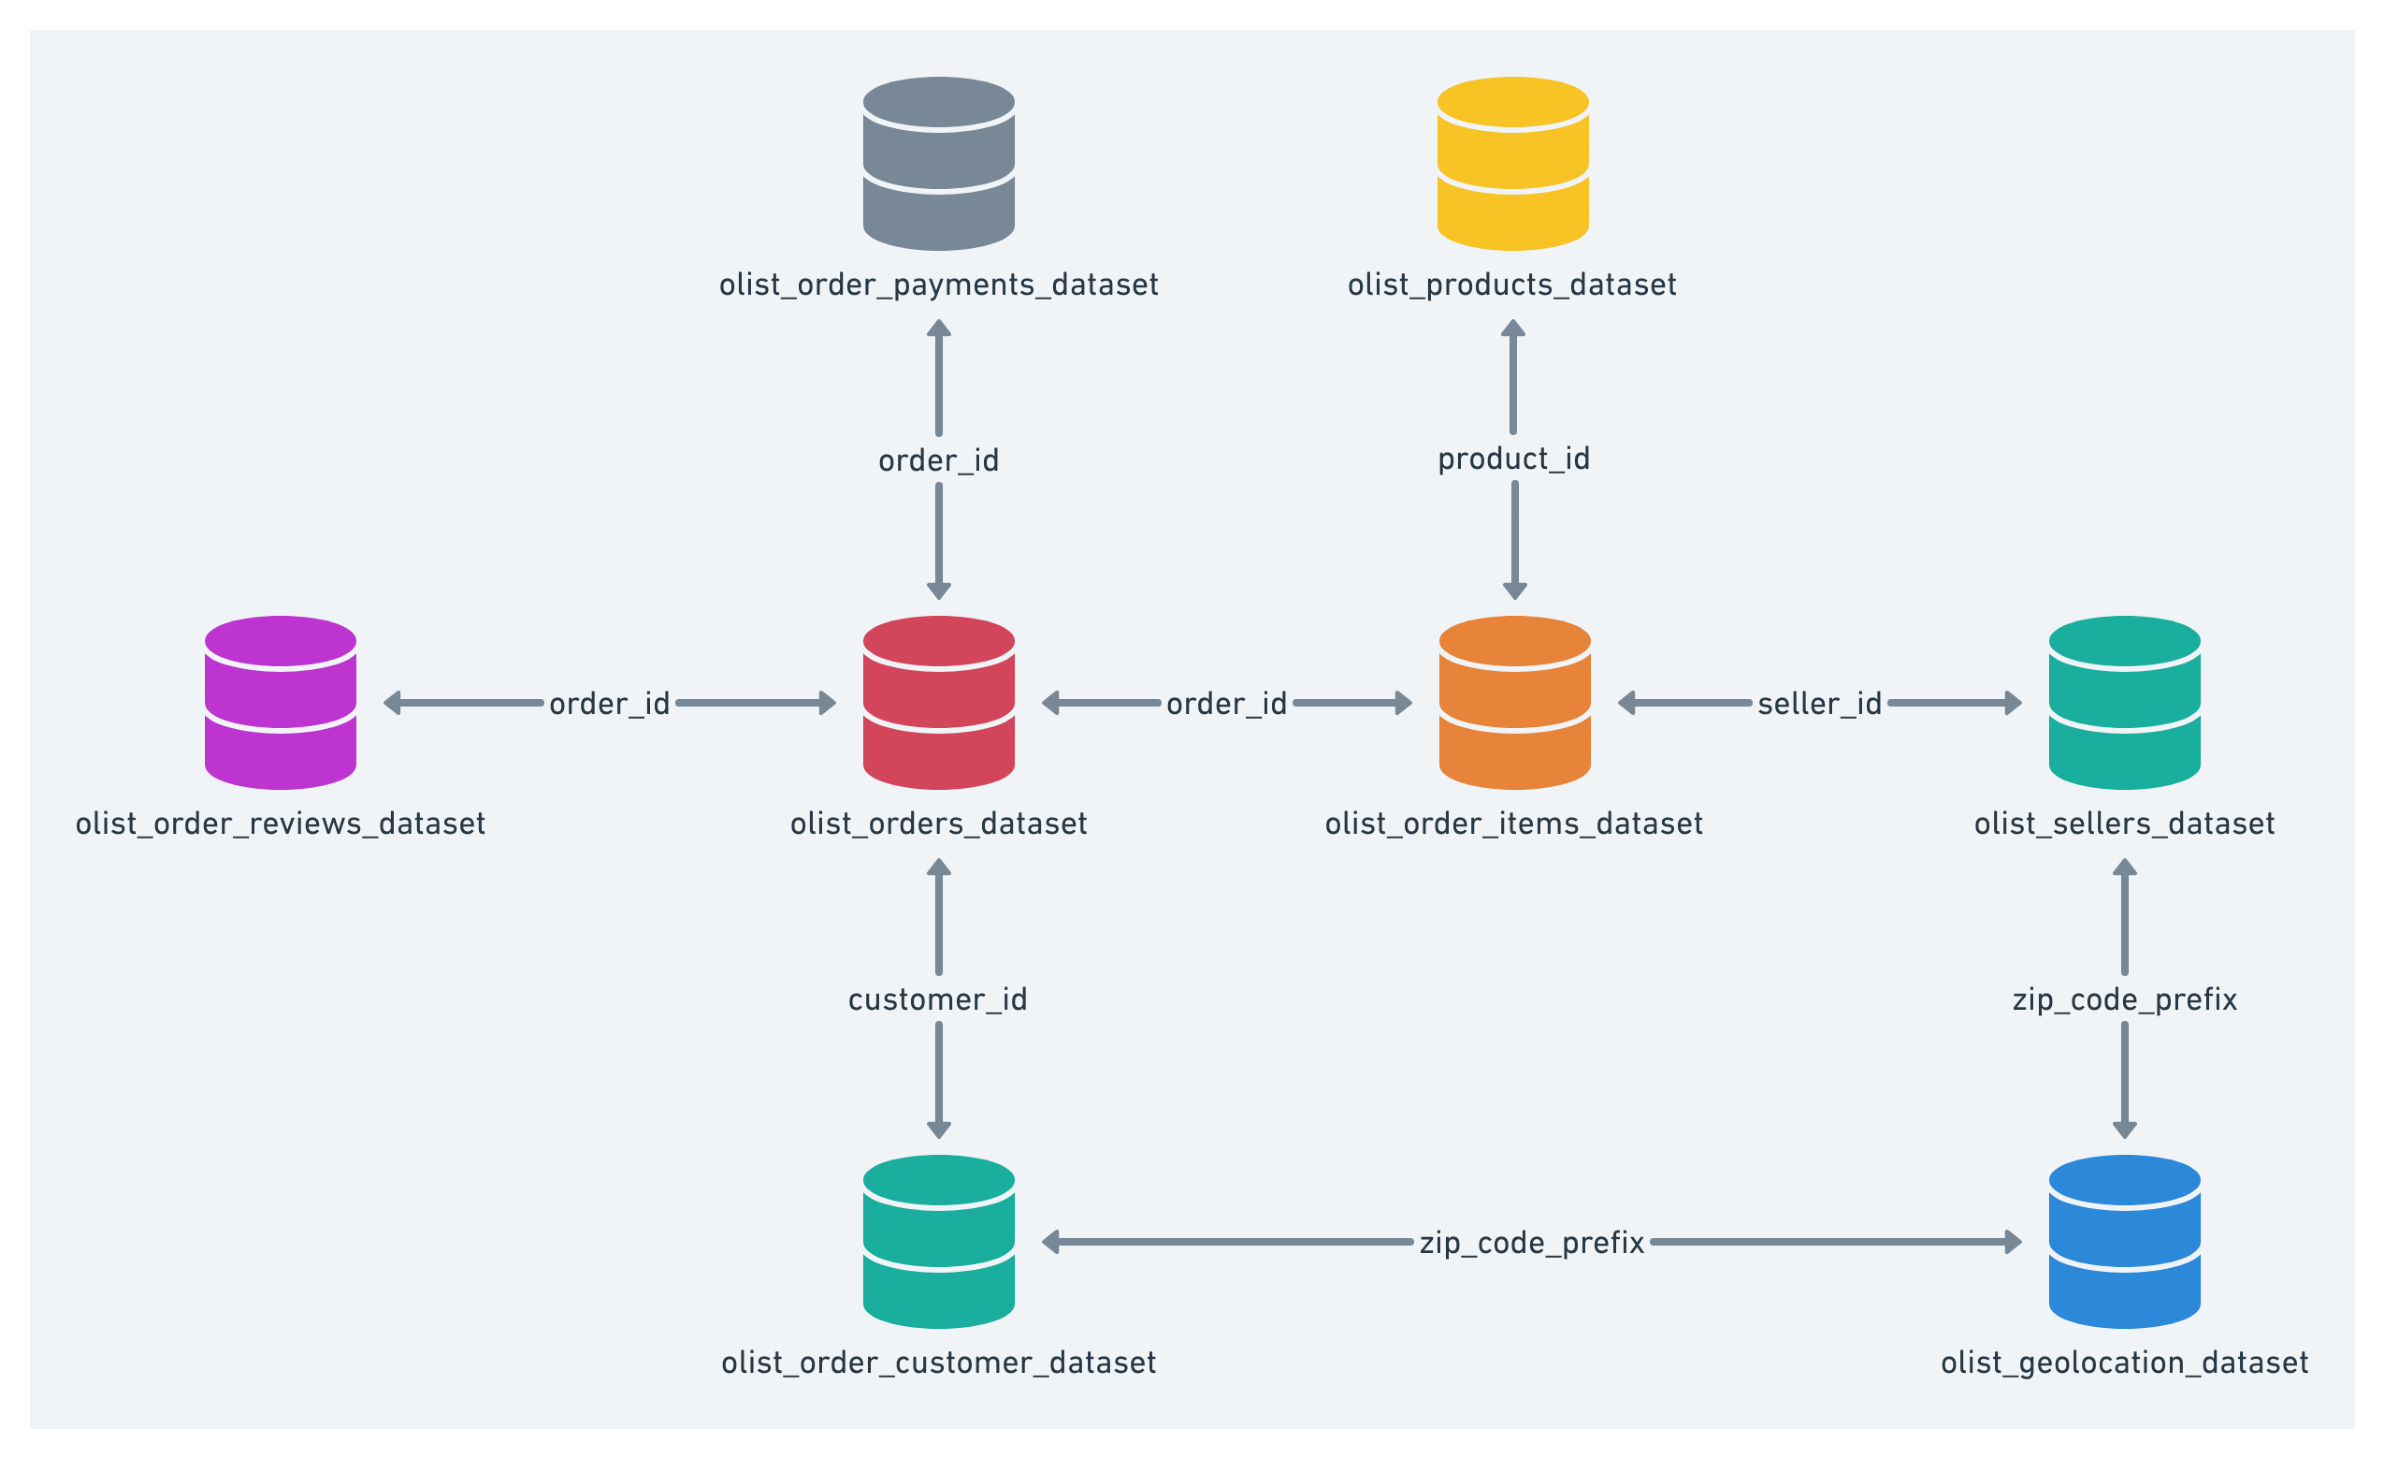

In [4]:
image = mpimg.imread('Dataset_Olist.png')

plt.figure(figsize=(10, 10), dpi=300) 
plt.imshow(image)
plt.axis('off')
plt.show()

Le jeu de données fourni est constitué de données historiques de commandes de 2016 à 2018 et contient 100 000 commandes. Il y a 8 fichiers disponibles. Le modèle de données ci-dessous affiche à haut niveau les références entre ces tables de données et de consultation. Les données ont été fournies par Olist sous la licence CC BY-NC-SA 4.0 et peuvent être trouvées sur Kaggle à cette adresse : https://www.kaggle.com/olistbr/brazilian-ecommerce

## 1.1 Order_items dataset

Cette table contient les commandes en détail avec les UGS (Unité de Gestion des Stocks, ou SKU en anglais, autrement dit l'ID du produit), le vendeur et les prix.

In [5]:
order_items.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  
0  2017-09-19 09:45:35   58.90          13.29  
1  2017-05-03 11:05:13  239.90          19.93  
2  2018-01-18 14:48:30  199.00          17.87  
3  2018-08-15 10:10:18   12.99          12.79  
4  2017-02-13 13:57:51  199.90          18.14

In [6]:
order_items.shape

(112650, 7)

Nombre total de cellules manquantes : 0
Nombre de cellules manquantes en % : 0.00%


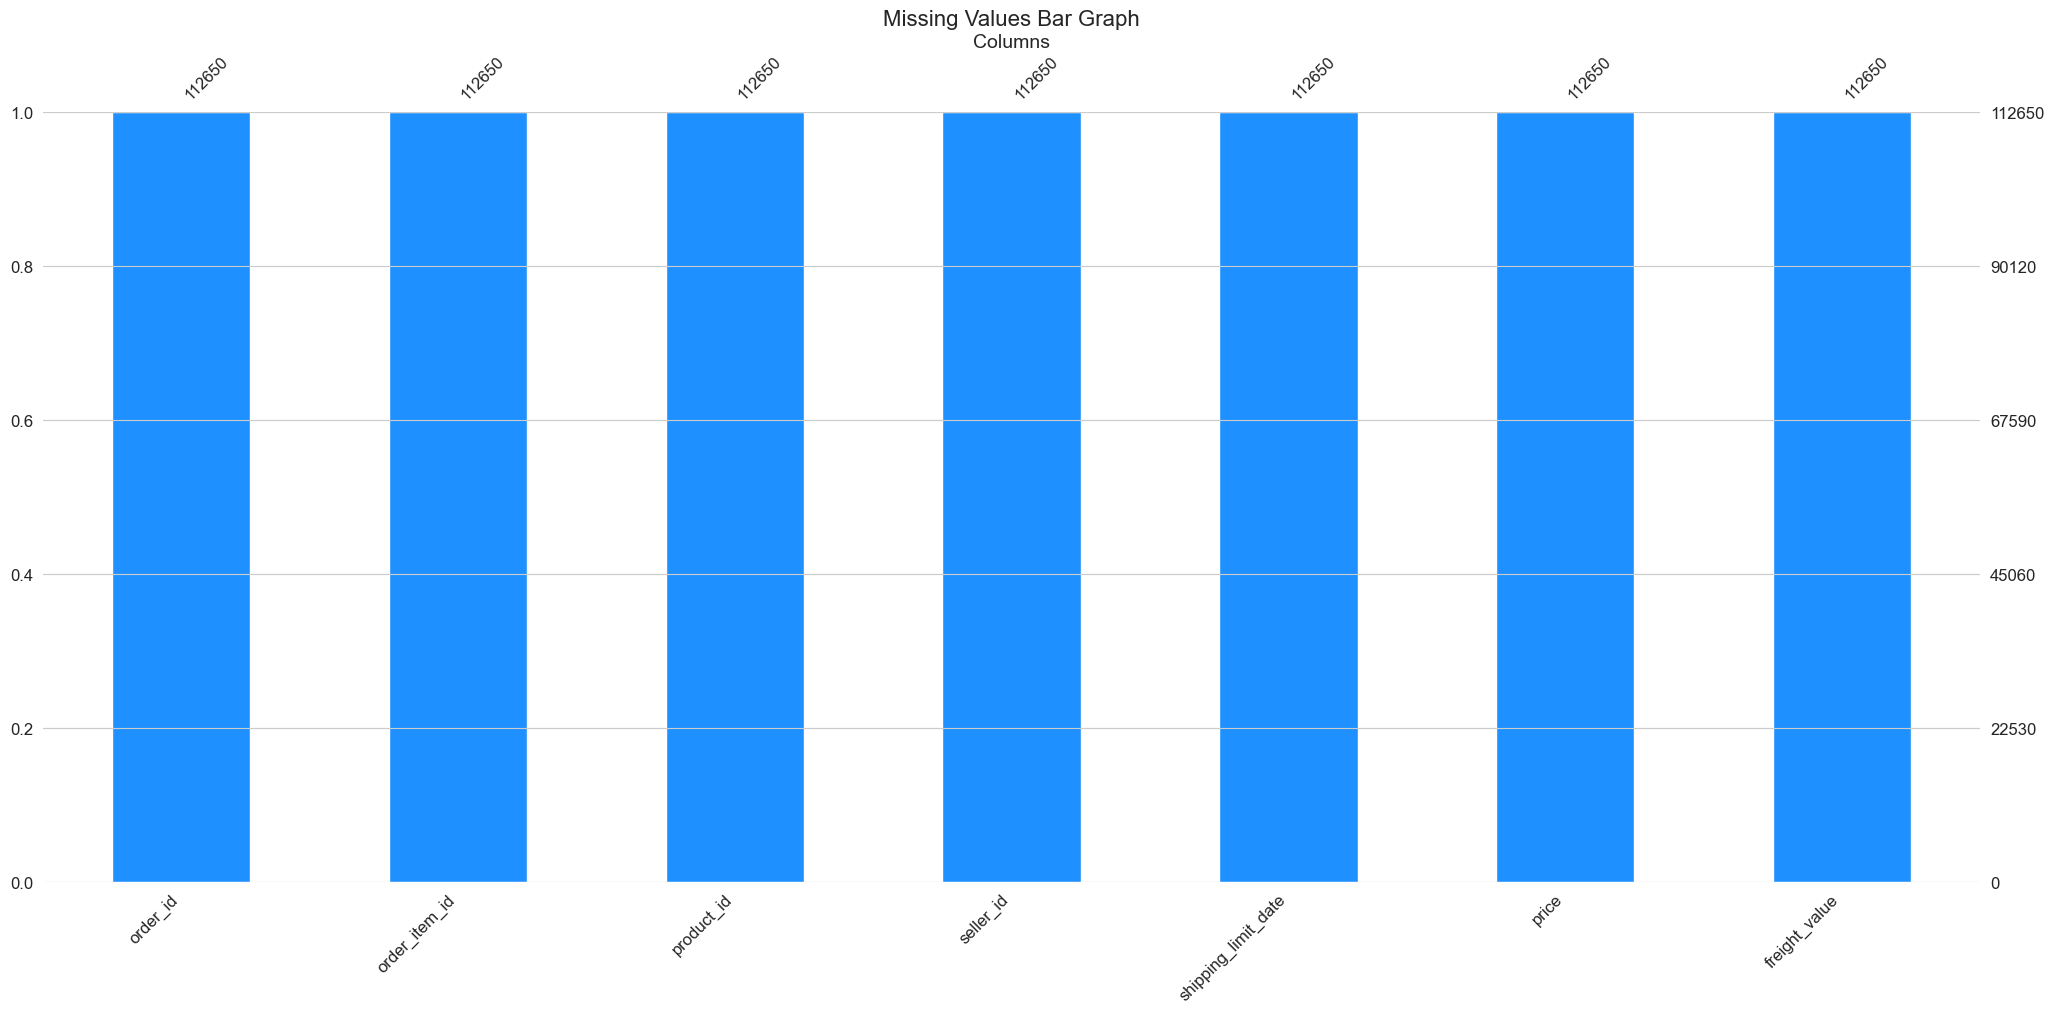

In [7]:
from fonctions import analyze_missing_data
from fonctions import generate_missingno_bar_graph

analyze_missing_data(order_items)
generate_missingno_bar_graph(order_items)

In [8]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [9]:
# Vérification du nombre de commandes uniques

print('Total des order_id uniques dans la table order_item : {} \n\
Total des orders_item_id uniques dans la table order_item : {} \n\
Total des order_id uniques dans la table des commandes : {} \n\
Total des enregistrements dans order_items : {}'.format(
    order_items['order_id'].nunique(),
    order_items['order_item_id'].nunique(),
    order_items['order_id'].nunique(), len(order_items)))

Total des order_id uniques dans la table order_item : 98666 
Total des orders_item_id uniques dans la table order_item : 21 
Total des order_id uniques dans la table des commandes : 98666 
Total des enregistrements dans order_items : 112650


In [10]:
# Vérification de la cohérence des commandes

order_items['order_id'].isin(orders['order_id']).value_counts()

True    112650
Name: order_id, dtype: int64

- Cela signifie que tous les order_id présents dans order_items existent bien dans orders 
- Aucune ligne ne retourne False, donc il n’y a pas d'articles associés à des commandes inexistantes.

<Axes: >

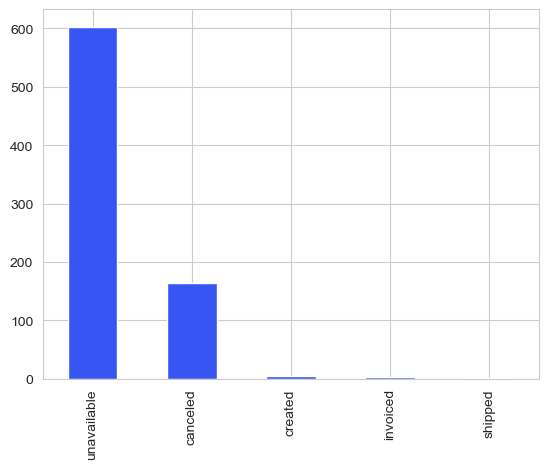

In [11]:
# Analyse des commandes absentes dans order_items

orders[~orders['order_id'].isin(order_items['order_id'])]['order_status'].value_counts().plot(kind='bar')

In [12]:
orders['order_status'].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

Nous constatons que les commandes sans détails sont systématiquement associées aux statuts "indisponibles" ou "annulées", indiquant une non-finalisation de la commande. Ces lignes seront donc supprimées du jeu de données.

In [13]:
orders = orders[orders['order_id'].isin(
order_items['order_id'])]

In [14]:
orders

order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4      ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                 ...                               ...   
99436  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99437  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99438  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99439  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99440  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_status order_purchase_timestamp    order_approved_at  \
0        delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1        delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2        delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3        delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4        delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   
...            ...                      ...                  ...   
99436    delivered      2017-03-09 09:54:05  2017-03-09 09:54:05   
99437    delivered      2018-02-06 12:58:58  2018-02-06 13:10:37   
99438    delivered      2017-08-27 14:46:43  2017-08-27 15:04:16   
99439    delivered      2018-01-08 21:28:27  2018-01-08 21:36:21   
99440    delivered      2018-03-08 20:57:30  2018-03-09 11:20:28   

      order_delivered_carrier_date order_delivered_customer_date  \
0              2017-10-04 19:55:00           2017-10-10 21:25:13   
1              2018-07-26 14:31:00           2018-08-07 15:27:45   
2              2018-08-08 13:50:00           2018-08-17 18:06:29   
3              2017-11-22 13:39:59           2017-12-02 00:28:42   
4              2018-02-14 19:46:34           2018-02-16 18:17:02   
...                            ...                           ...   
99436          2017-03-10 11:18:03           2017-03-17 15:08:01   
99437          2018-02-07 23:22:42           2018-02-28 17:37:56   
99438          2017-08-28 20:52:26           2017-09-21 11:24:17   
99439          2018-01-12 15:35:03           2018-01-25 23:32:54   
99440          2018-03-09 22:11:59           2018-03-16 13:08:30   

      order_estimated_delivery_date  
0               2017-10-18 00:00:00  
1               2018-08-13 00:00:00  
2               2018-09-04 00:00:00  
3               2017-12-15 00:00:00  
4               2018-02-26 00:00:00  
...                             ...  
99436           2017-03-28 00:00:00  
99437           2018-03-02 00:00:00  
99438           2017-09-27 00:00:00  
99439           2018-02-15 00:00:00  
99440           2018-04-03 00:00:00  

[98666 rows x 8 columns]

In [15]:
# Vérification des lignes et des commandes en double.
print('Nombre de lignes en double : {} \n\
Nombre de commandes en double: {}'.format(
order_items.duplicated().sum(),
order_items[['order_id', 'product_id']].duplicated().sum()))

Nombre de lignes en double : 0 
Nombre de commandes en double: 10225


Pourquoi y a-t-il des doublons de order_id + product_id ?

Habituellement, une table order_items contient une colonne "quantity" pour indiquer combien de fois un produit est commandé. Ici, il n'y a pas de colonne "quantity", donc chaque unité du même produit est enregistrée sur une ligne séparée.
Le order_item_id sert simplement d'index de position pour différencier ces lignes.

Solution : Ajouter une colonne "qty" pour la quantité de produits commandés
On peut créer une nouvelle colonne qty qui regroupe ces lignes en comptant le nombre de répétitions.

In [16]:
order_items.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  
0  2017-09-19 09:45:35   58.90          13.29  
1  2017-05-03 11:05:13  239.90          19.93  
2  2018-01-18 14:48:30  199.00          17.87  
3  2018-08-15 10:10:18   12.99          12.79  
4  2017-02-13 13:57:51  199.90          18.14

Ce dataset comprend des données sur les articles achetés dans chaque commande.

Il contient 112 650 observations et 7 variables et ne contient aucune données manquantes.

## 1.2 Order_payments dataset

In [17]:
order_pay.head()

order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39  
2                     1          65.71  
3                     8         107.78  
4                     2         128.45

In [18]:
order_pay.shape

(103886, 5)

Nombre total de cellules manquantes : 0
Nombre de cellules manquantes en % : 0.00%


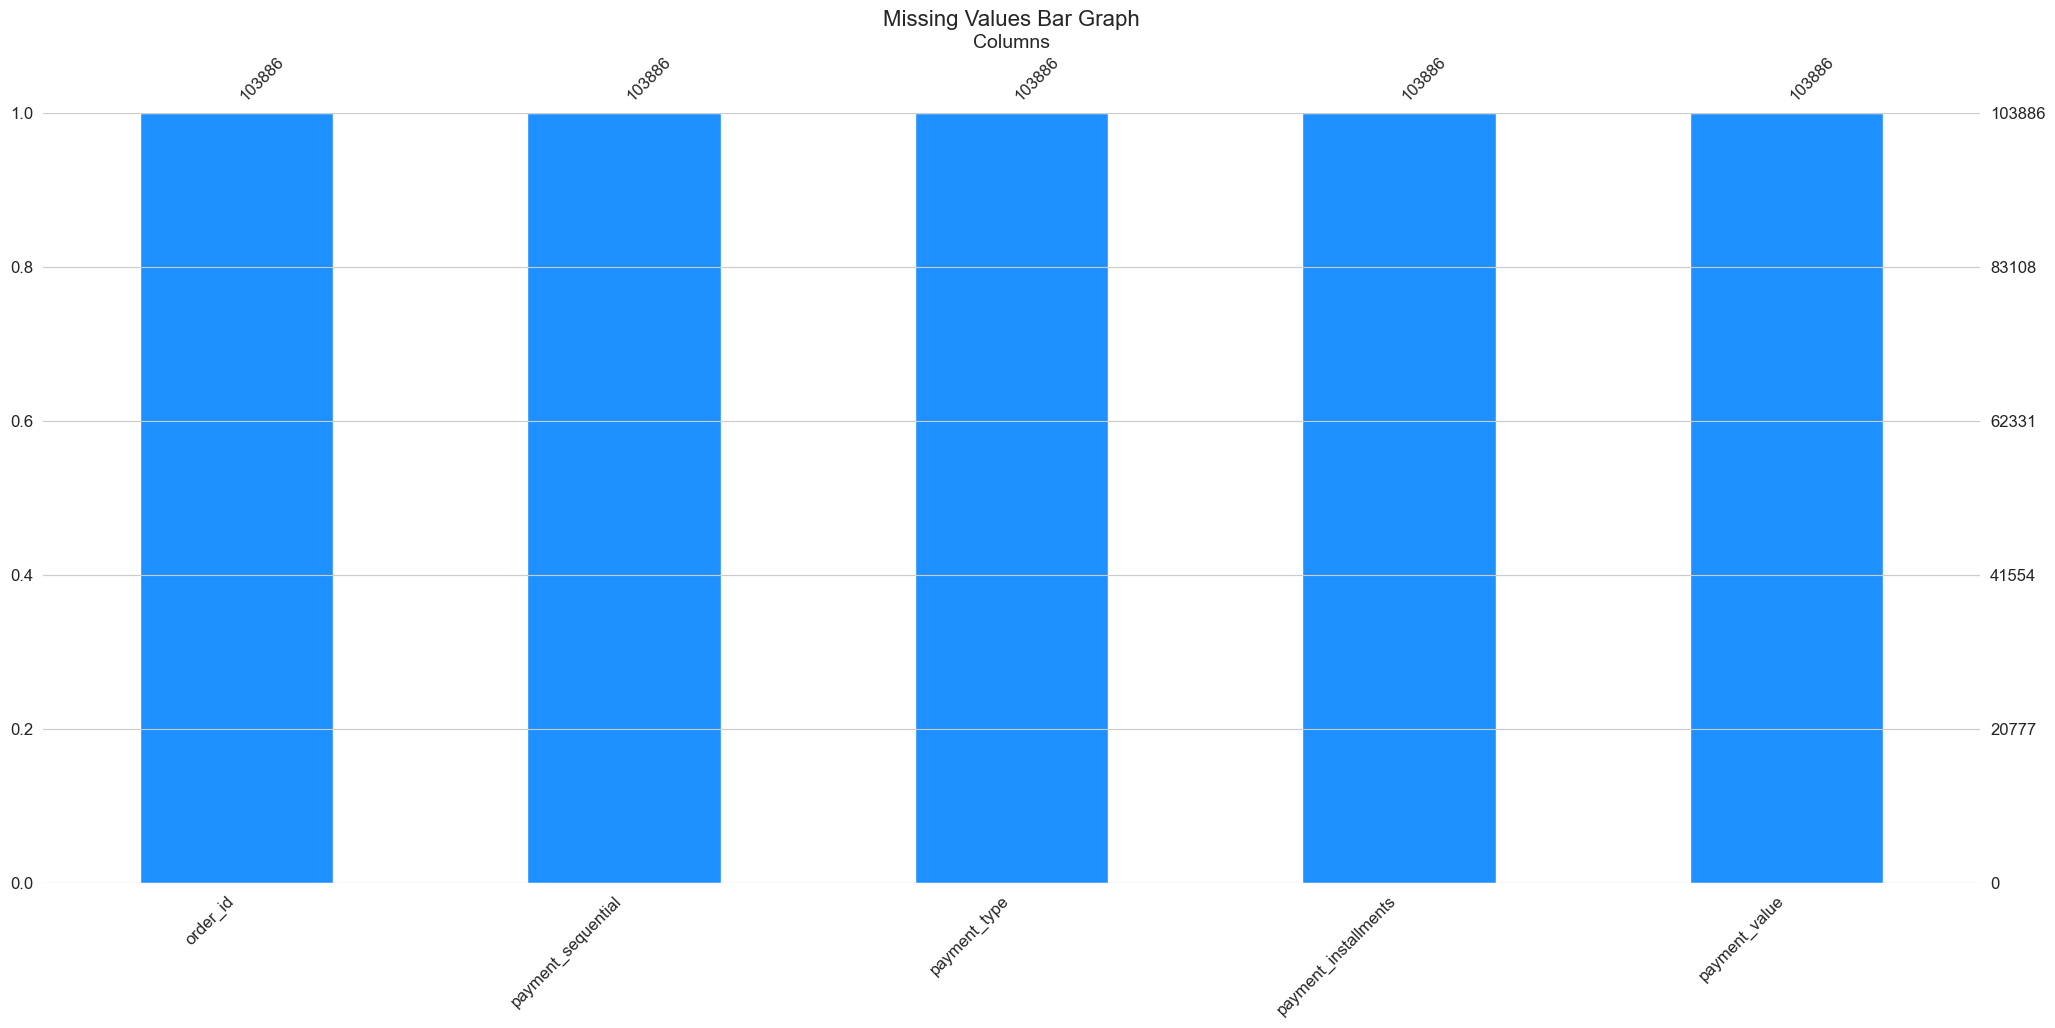

In [19]:
from fonctions import analyze_missing_data
from fonctions import generate_missingno_bar_graph

analyze_missing_data(order_pay)
generate_missingno_bar_graph(order_pay)

In [20]:
order_pay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


Ce dataset comprend des données sur les options de paiement des commandes. 

Il contient 103 886 observations et 5 variables et ne contient aucune données manquantes.

## 1.3 Order_reviews dataset

In [21]:
order_rev.head()

review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                  NaN   
1             5                  NaN   
2             5                  NaN   
3             5                  NaN   
4             5                  NaN   

                              review_comment_message review_creation_date  \
0                                                NaN  2018-01-18 00:00:00   
1                                                NaN  2018-03-10 00:00:00   
2                                                NaN  2018-02-17 00:00:00   
3              Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
4  Parabéns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   

  review_answer_timestamp  
0     2018-01-18 21:46:59  
1     2018-03-11 03:05:13  
2     2018-02-18 14:36:24  
3     2017-04-21 22:02:06  
4     2018-03-02 10:26:53

In [22]:
order_rev.shape

(99224, 7)

Nombre total de cellules manquantes : 145903
Nombre de cellules manquantes en % : 21.01%


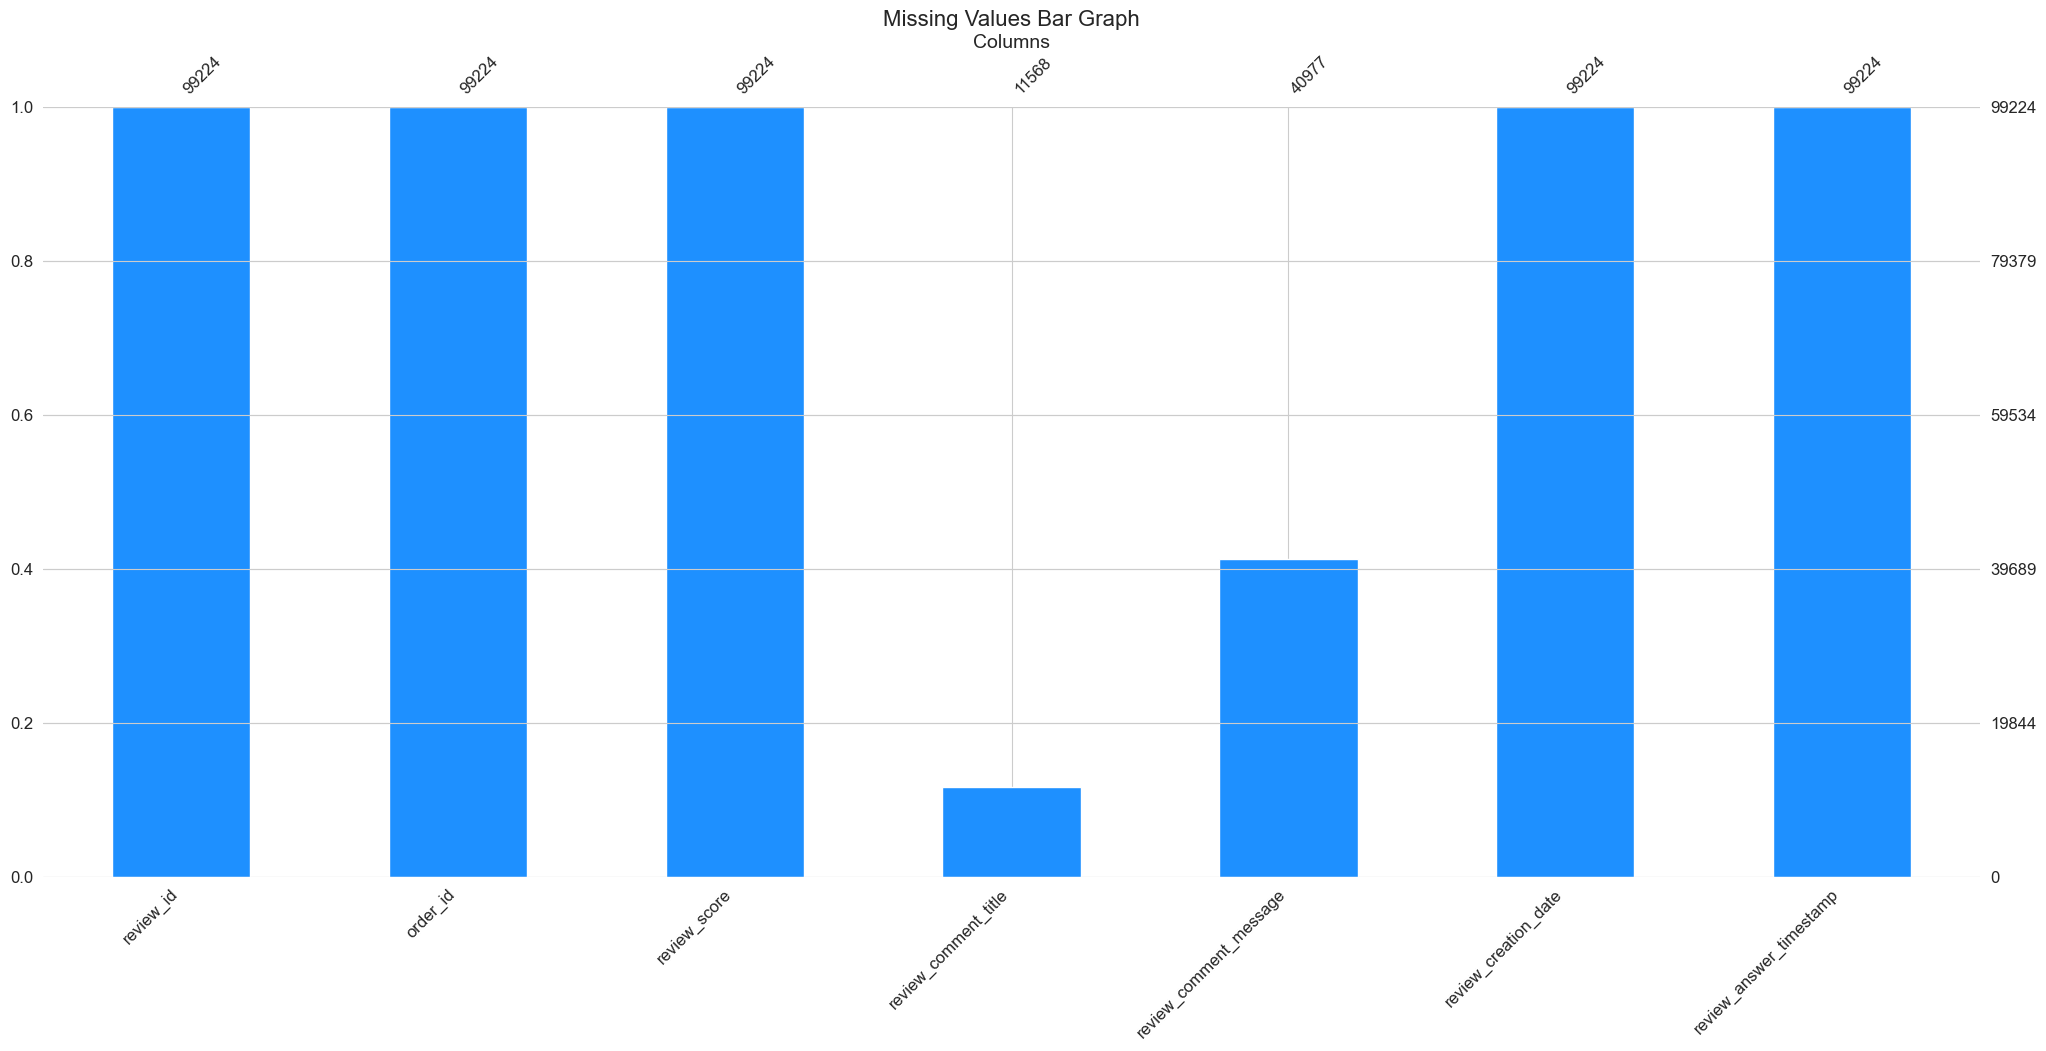

In [23]:
from fonctions import analyze_missing_data
from fonctions import generate_missingno_bar_graph

analyze_missing_data(order_rev)
generate_missingno_bar_graph(order_rev)

In [24]:
from fonctions import valeurs_manquantes

valeurs_manquantes(order_rev)

Variable  Missing values  Missing (%)
0                review_id               0     0.000000
1                 order_id               0     0.000000
2             review_score               0     0.000000
3     review_comment_title           87656     0.883415
4   review_comment_message           58247     0.587025
5     review_creation_date               0     0.000000
6  review_answer_timestamp               0     0.000000

In [25]:
order_rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


## 1.4 Orders dataset

La table des données des commandes contient les ID de commande avec horodatage et l'ID du client.

In [26]:
orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
2           2018-09-04 00:00:00  
3           2017-12-15 00:00:00  
4           2018-02-26 00:00:00

In [27]:
order_rev.shape

(99224, 7)

Nombre total de cellules manquantes : 3213
Nombre de cellules manquantes en % : 0.41%


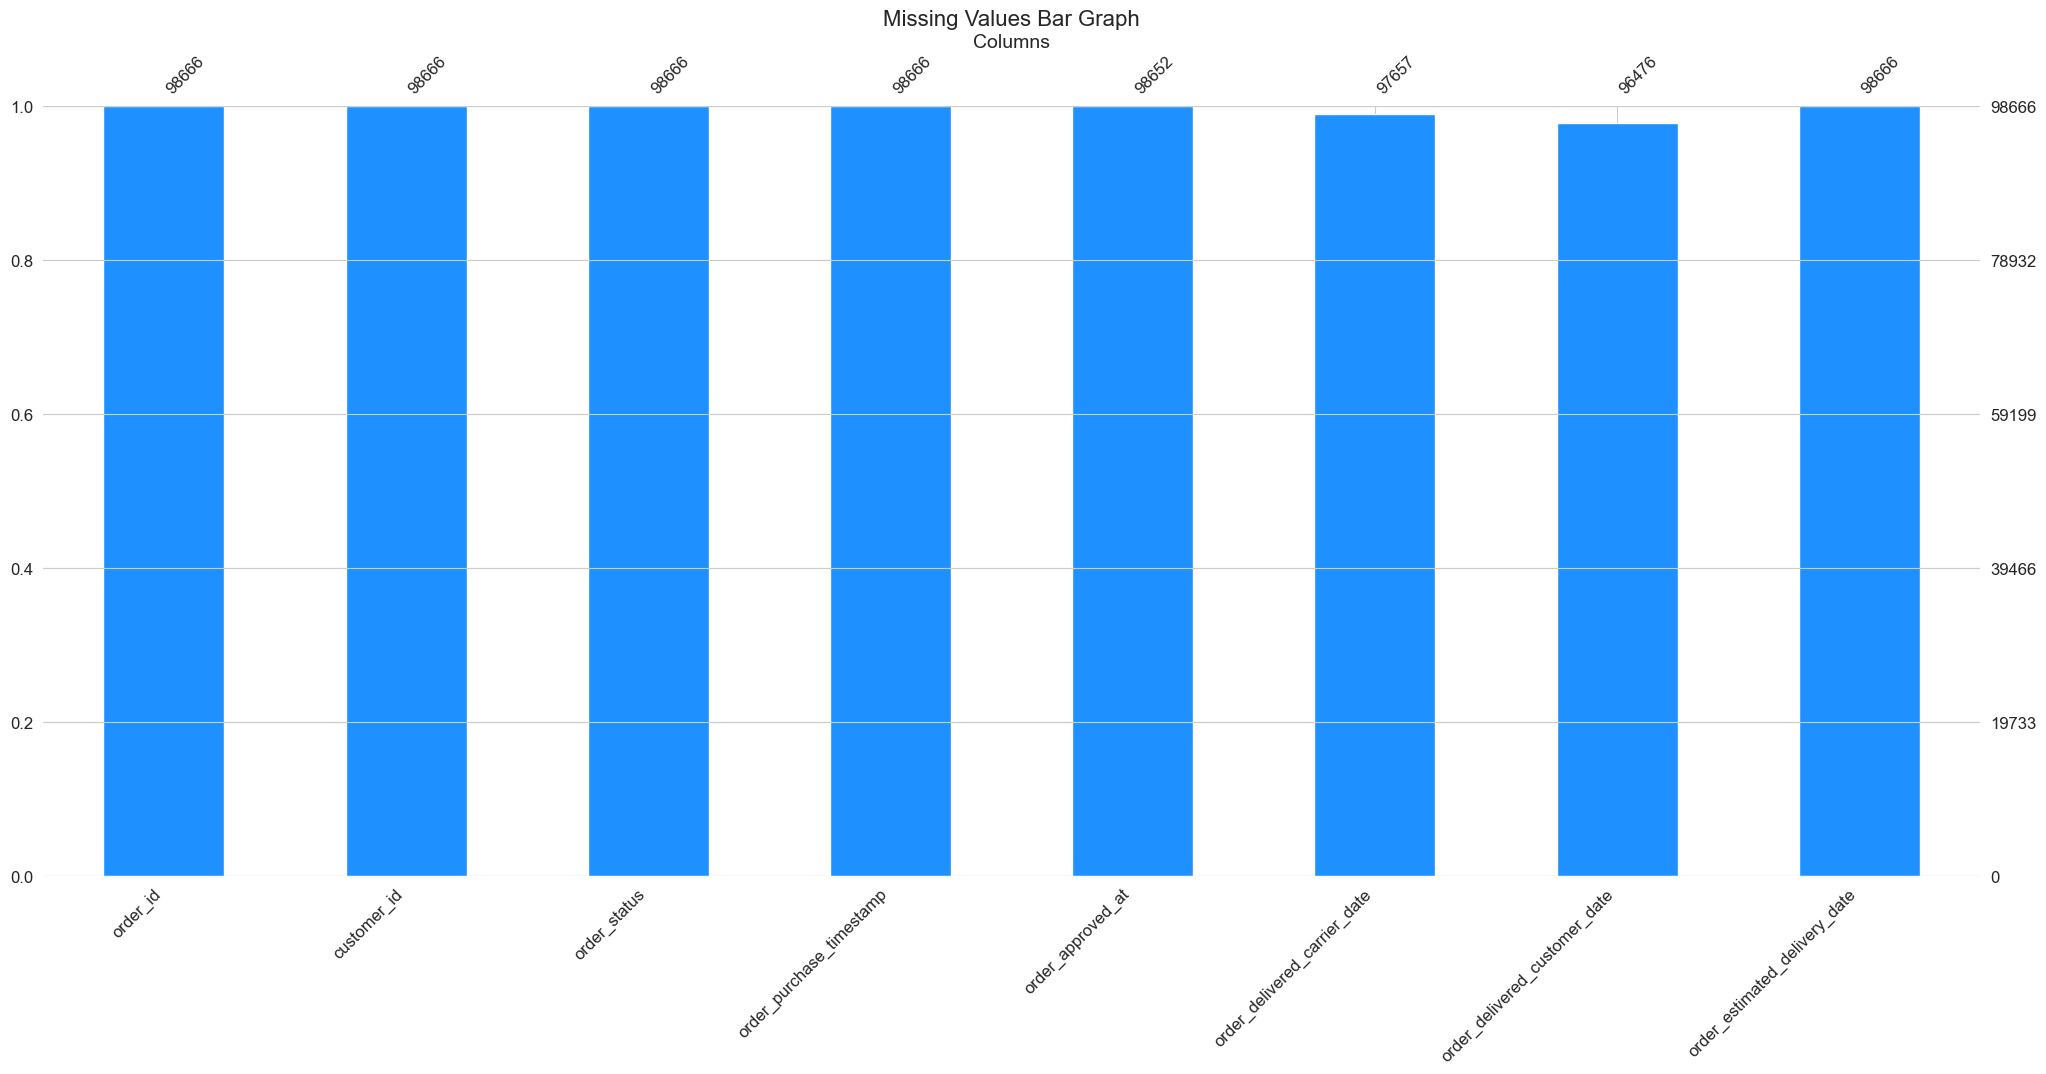

In [28]:
from fonctions import analyze_missing_data
from fonctions import generate_missingno_bar_graph

analyze_missing_data(orders)
generate_missingno_bar_graph(orders)

In [29]:
from fonctions import valeurs_manquantes

valeurs_manquantes(orders)

Variable  Missing values  Missing (%)
0                       order_id               0     0.000000
1                    customer_id               0     0.000000
2                   order_status               0     0.000000
3       order_purchase_timestamp               0     0.000000
4              order_approved_at              14     0.000142
5   order_delivered_carrier_date            1009     0.010226
6  order_delivered_customer_date            2190     0.022196
7  order_estimated_delivery_date               0     0.000000

In [30]:
# Affichage des catégories uniques
unique_categories = orders['order_status'].unique()
print(unique_categories)

['delivered' 'invoiced' 'shipped' 'processing' 'canceled' 'unavailable'
 'approved']


In [31]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98666 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       98666 non-null  object
 1   customer_id                    98666 non-null  object
 2   order_status                   98666 non-null  object
 3   order_purchase_timestamp       98666 non-null  object
 4   order_approved_at              98652 non-null  object
 5   order_delivered_carrier_date   97657 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  98666 non-null  object
dtypes: object(8)
memory usage: 6.8+ MB


## 1.5 Products dataset

In [32]:
prod.head()

product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0

In [33]:
prod.shape

(32951, 9)

Nombre total de cellules manquantes : 2448
Nombre de cellules manquantes en % : 0.83%


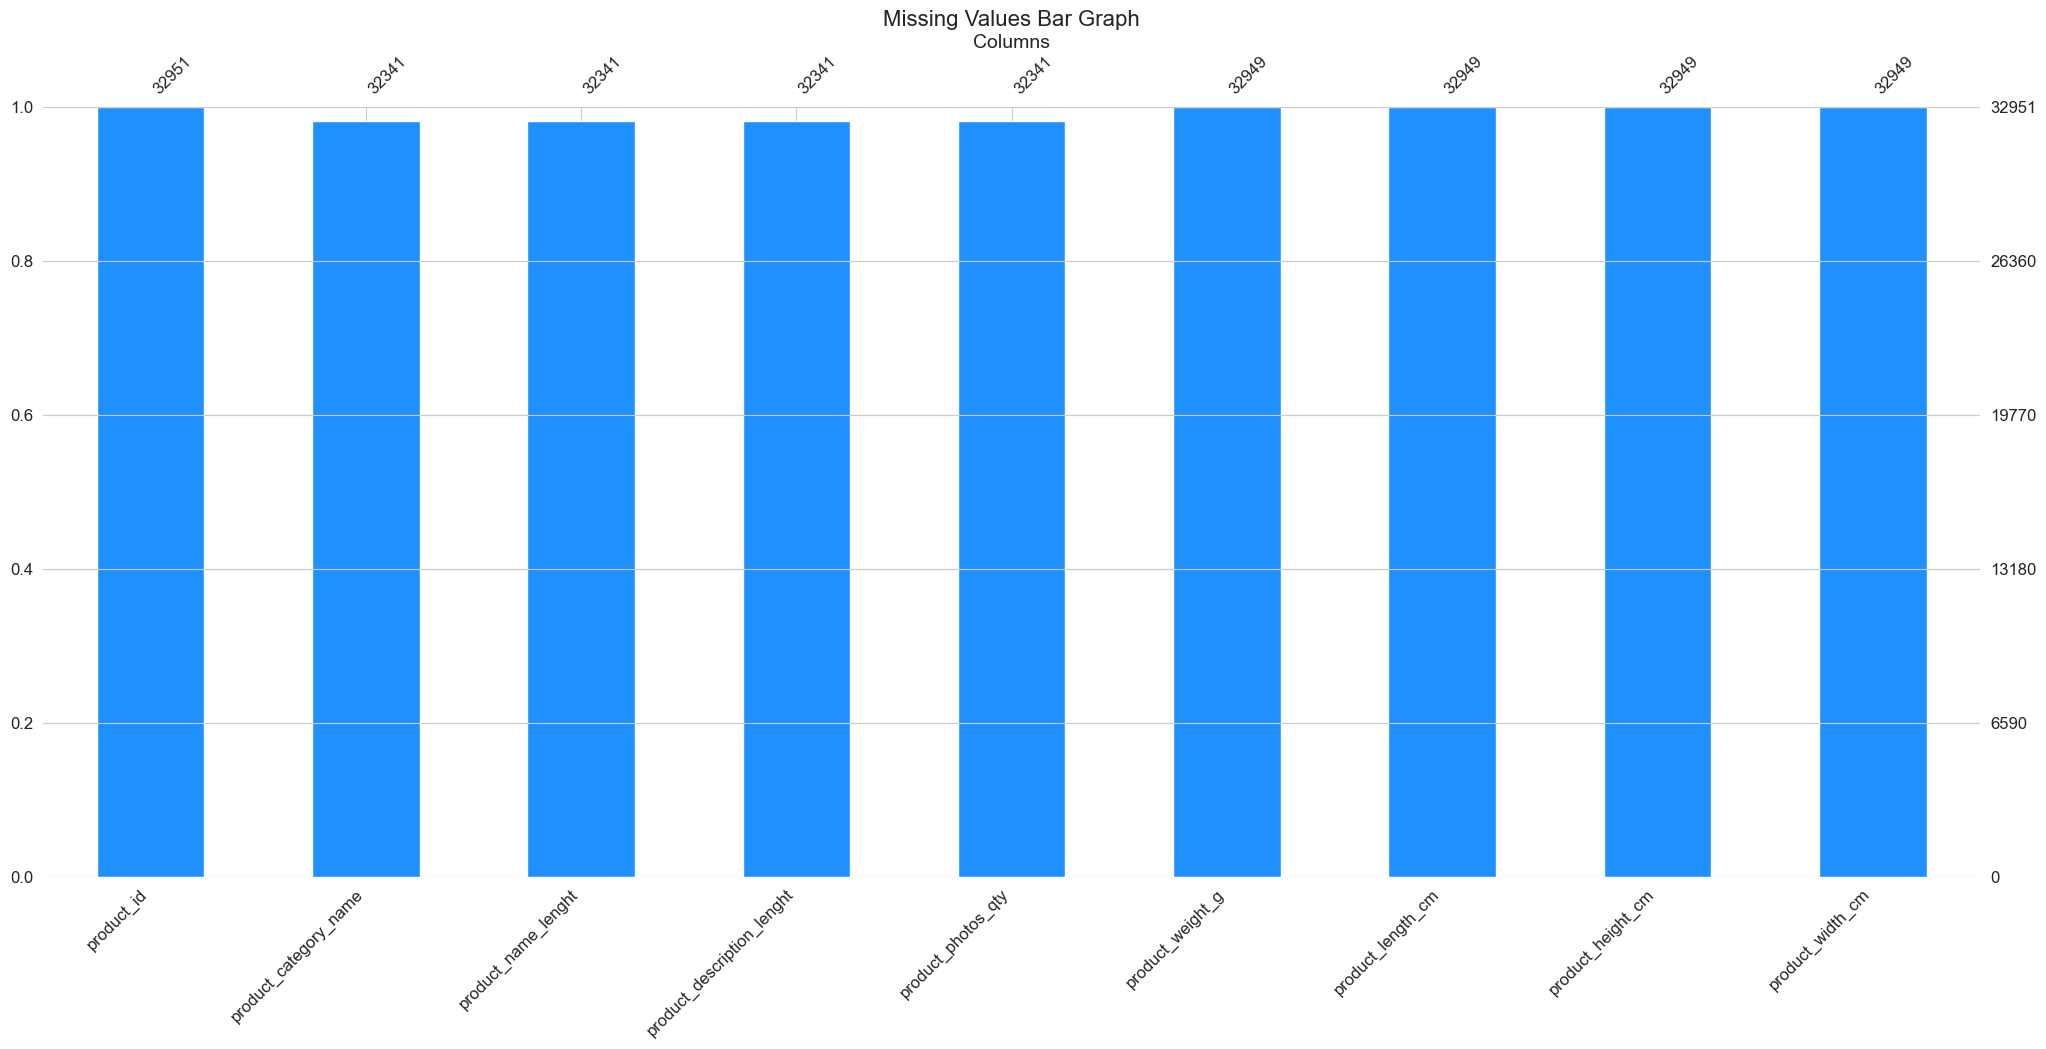

In [34]:
from fonctions import analyze_missing_data
from fonctions import generate_missingno_bar_graph

analyze_missing_data(prod)
generate_missingno_bar_graph(prod)

In [35]:
from fonctions import valeurs_manquantes

valeurs_manquantes(prod)

Variable  Missing values  Missing (%)
0                  product_id               0     0.000000
1       product_category_name             610     0.018512
2         product_name_lenght             610     0.018512
3  product_description_lenght             610     0.018512
4          product_photos_qty             610     0.018512
5            product_weight_g               2     0.000061
6           product_length_cm               2     0.000061
7           product_height_cm               2     0.000061
8            product_width_cm               2     0.000061

In [36]:
prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


## 1.6 Customers dataset

In [37]:
cust.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP

In [38]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [39]:
cust.shape

(99441, 5)

Nombre total de cellules manquantes : 0
Nombre de cellules manquantes en % : 0.00%


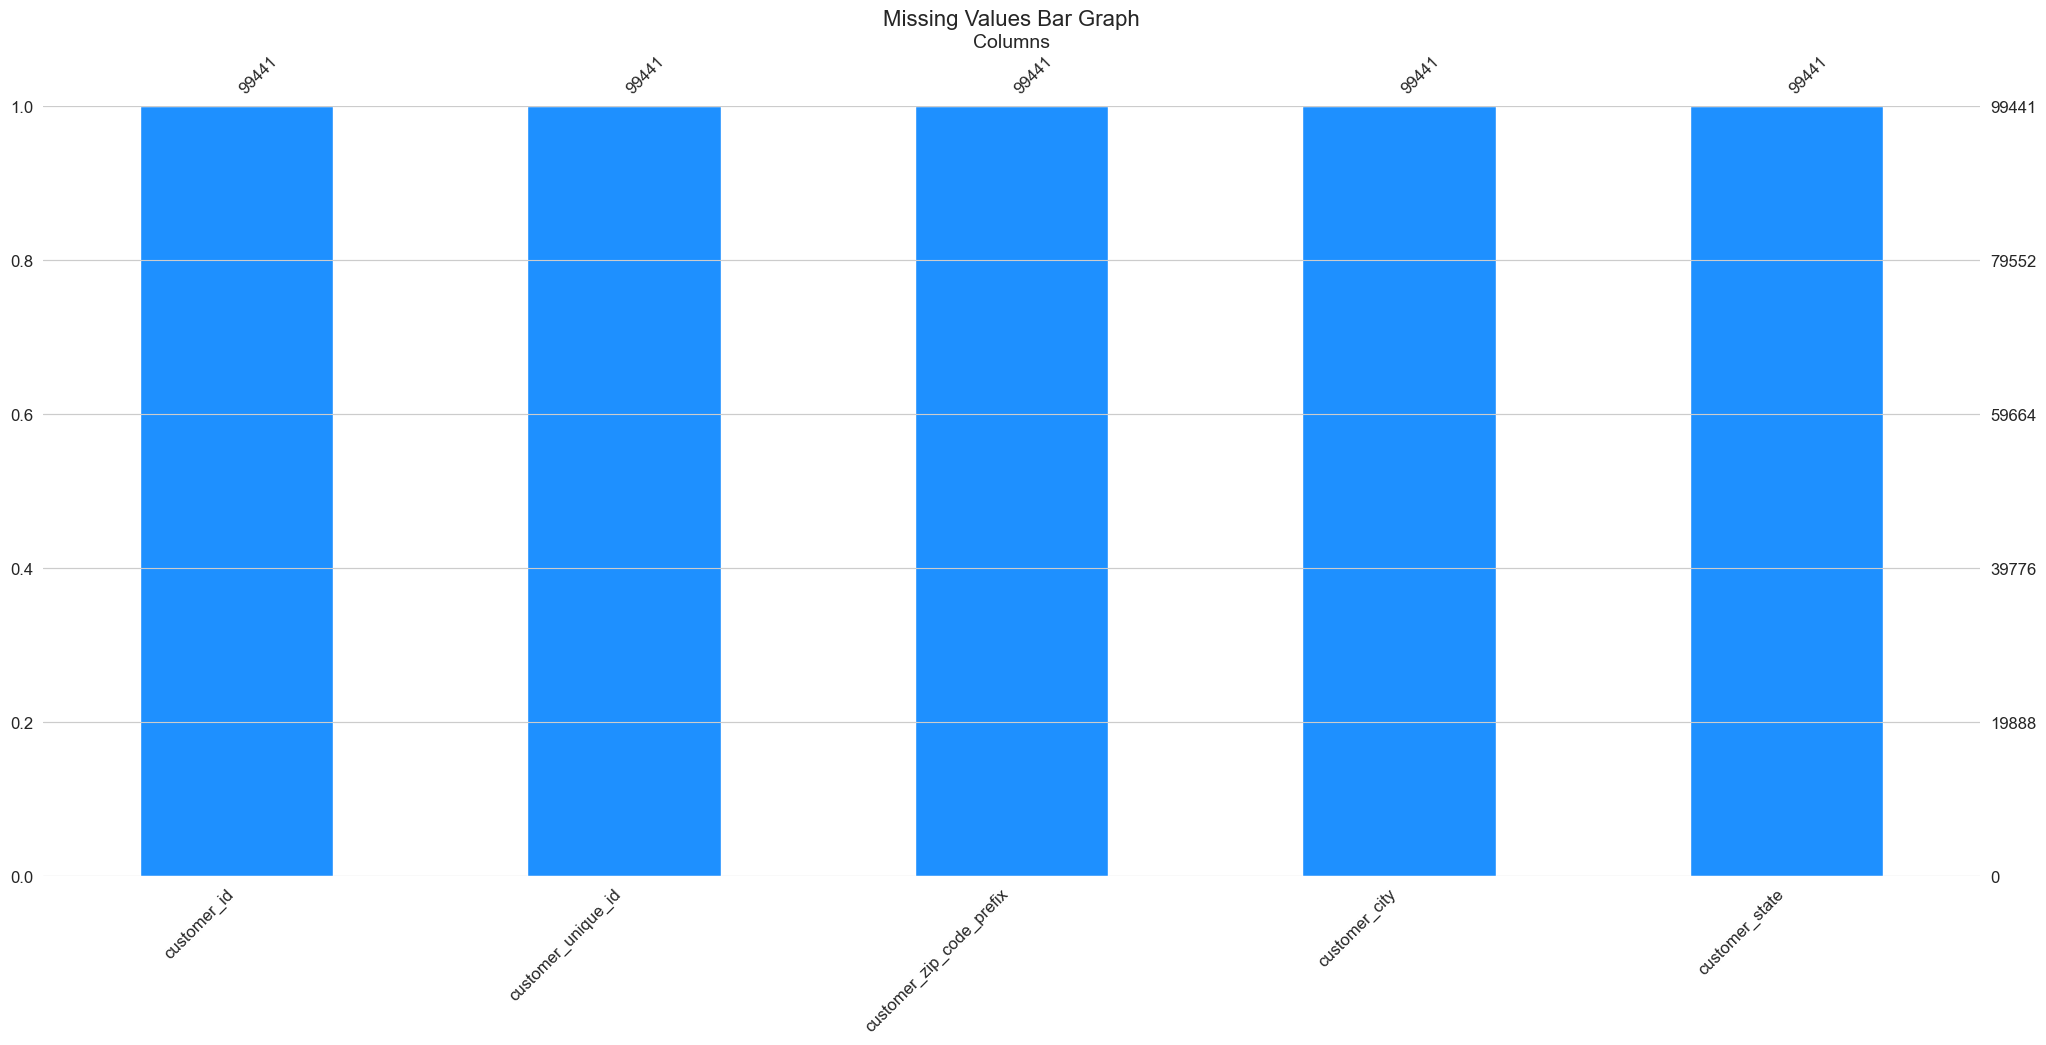

In [40]:
from fonctions import analyze_missing_data
from fonctions import generate_missingno_bar_graph

analyze_missing_data(cust)
generate_missingno_bar_graph(cust)

Il est intéressant de noter qu'il y a deux identifications du client, l'une étant un "identifiant unique" (customer_unique_id) et customer_id comme clé primaire reliée à la table des commandes. Cela signifie que le champ customer_id n'est en fait pas un identifiant unique pour le client. Il pourrait y avoir deux commandes avec des id_client différents alors qu'en réalité ces commandes proviennent du même client.

In [41]:
cust['customer_id'].nunique()

99441

In [42]:
cust['customer_unique_id'].nunique()

96096

## 1.7 Geolocalisation dataset

In [43]:
geo.head()

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                         1037       -23.545621       -46.639292   
1                         1046       -23.546081       -46.644820   
2                         1046       -23.546129       -46.642951   
3                         1041       -23.544392       -46.639499   
4                         1035       -23.541578       -46.641607   

  geolocation_city geolocation_state  
0        sao paulo                SP  
1        sao paulo                SP  
2        sao paulo                SP  
3        sao paulo                SP  
4        sao paulo                SP

In [44]:
geo.shape

(1000163, 5)

Nombre total de cellules manquantes : 0
Nombre de cellules manquantes en % : 0.00%


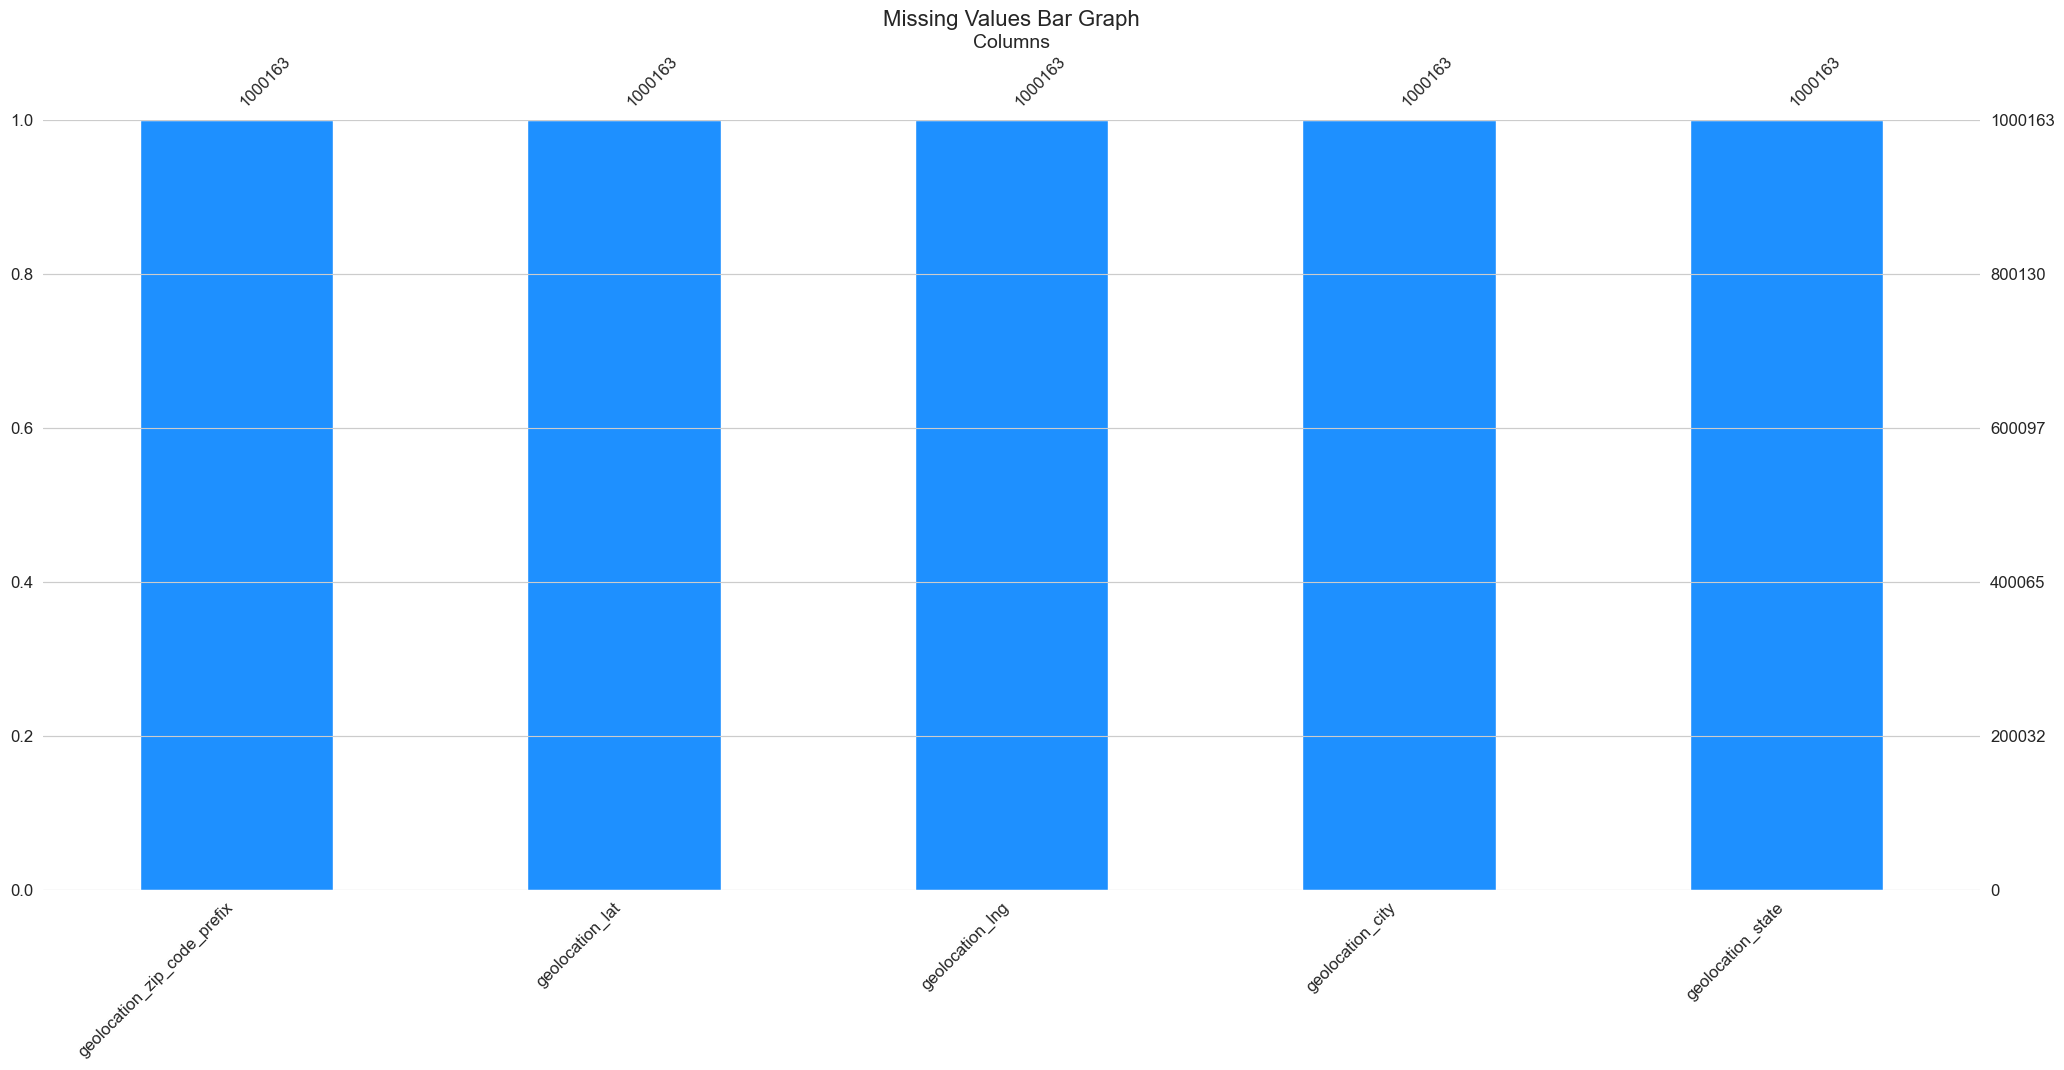

In [45]:
from fonctions import analyze_missing_data
from fonctions import generate_missingno_bar_graph

analyze_missing_data(geo)
generate_missingno_bar_graph(geo)

In [46]:
geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


## 1.8 Sellers dataset

In [47]:
sell.head()

seller_id  seller_zip_code_prefix  \
0  3442f8959a84dea7ee197c632cb2df15                   13023   
1  d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2  ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3  c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4  51a04a8a6bdcb23deccc82b0b80742cf                   12914   

         seller_city seller_state  
0           campinas           SP  
1         mogi guacu           SP  
2     rio de janeiro           RJ  
3          sao paulo           SP  
4  braganca paulista           SP

In [48]:
sell.shape

(3095, 4)

Nombre total de cellules manquantes : 0
Nombre de cellules manquantes en % : 0.00%


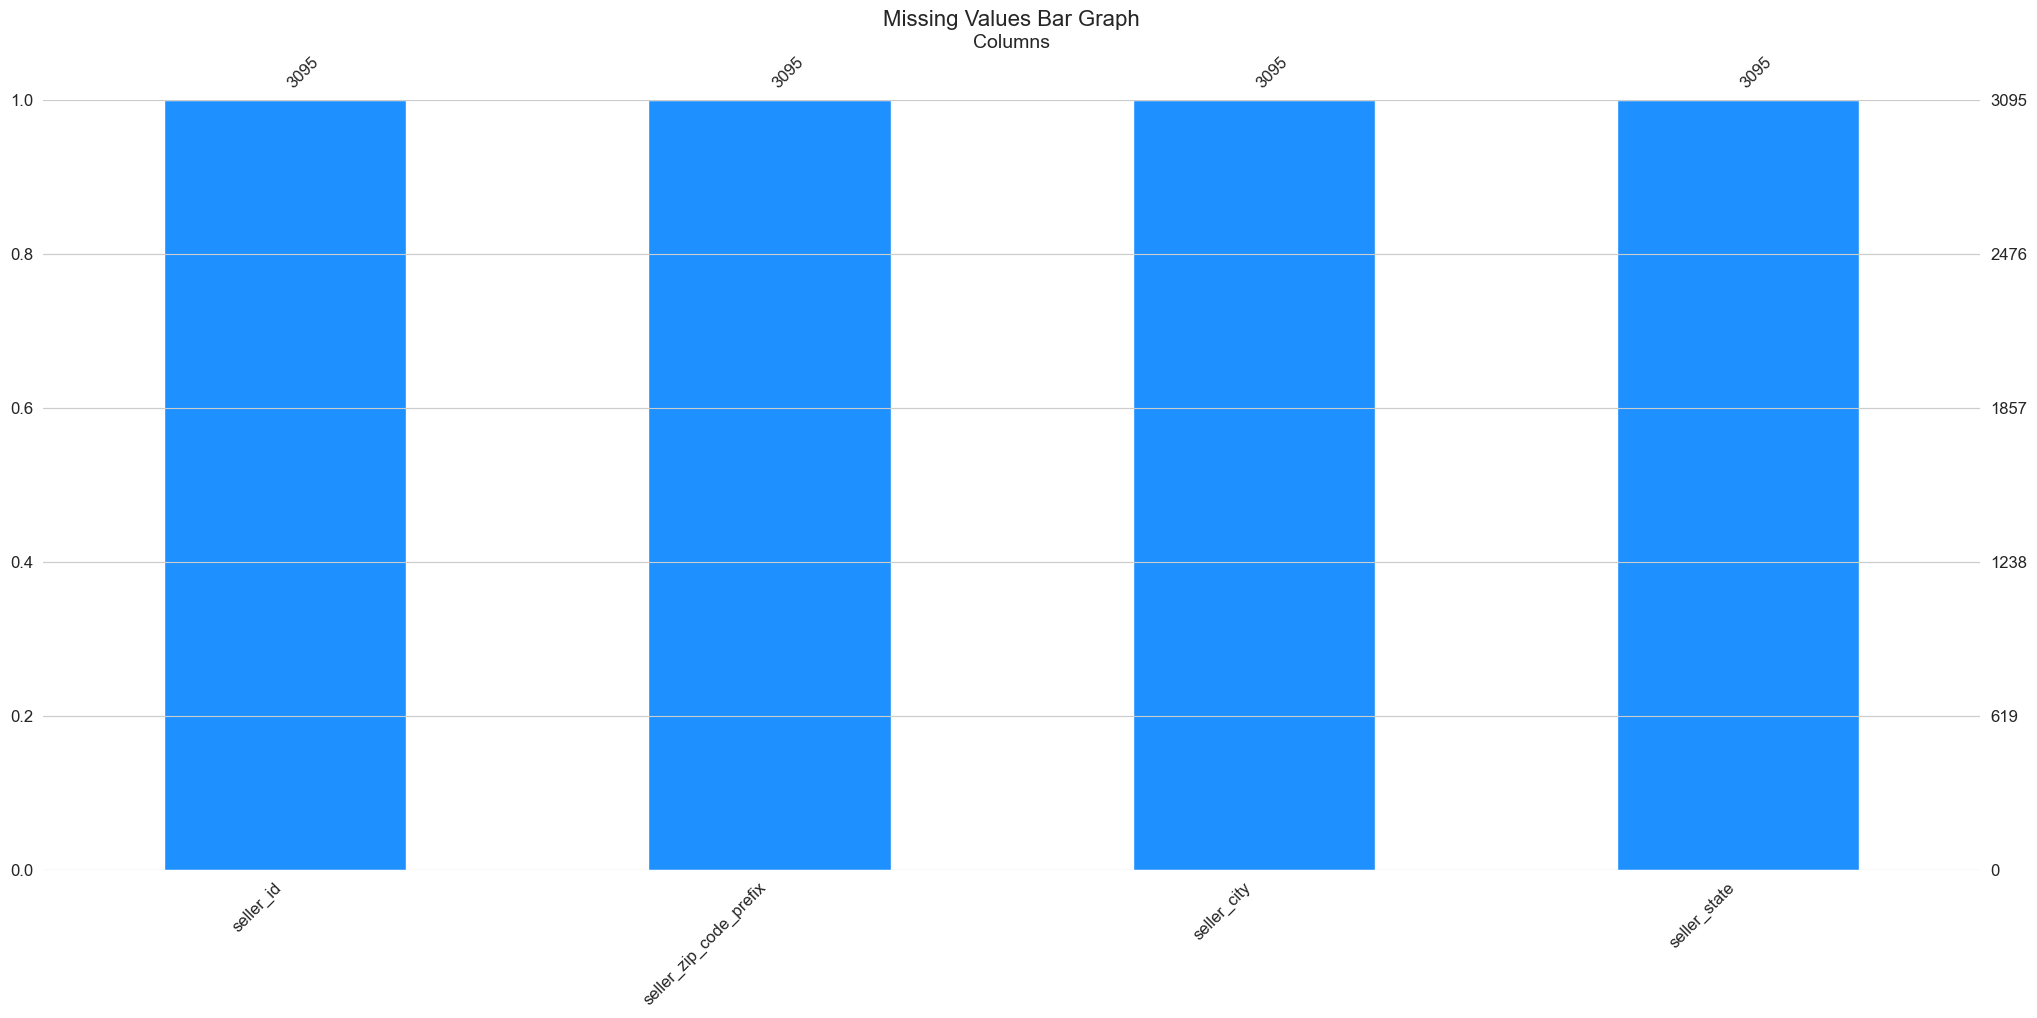

In [49]:
from fonctions import analyze_missing_data
from fonctions import generate_missingno_bar_graph

analyze_missing_data(sell)
generate_missingno_bar_graph(sell)

In [50]:
sell.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


## 1.9 Product_category_name_translation dataset

In [51]:
cat.head()

product_category_name product_category_name_english
0            beleza_saude                 health_beauty
1  informatica_acessorios         computers_accessories
2              automotivo                          auto
3         cama_mesa_banho                bed_bath_table
4        moveis_decoracao               furniture_decor

In [52]:
cat.shape

(71, 2)

Nombre total de cellules manquantes : 0
Nombre de cellules manquantes en % : 0.00%


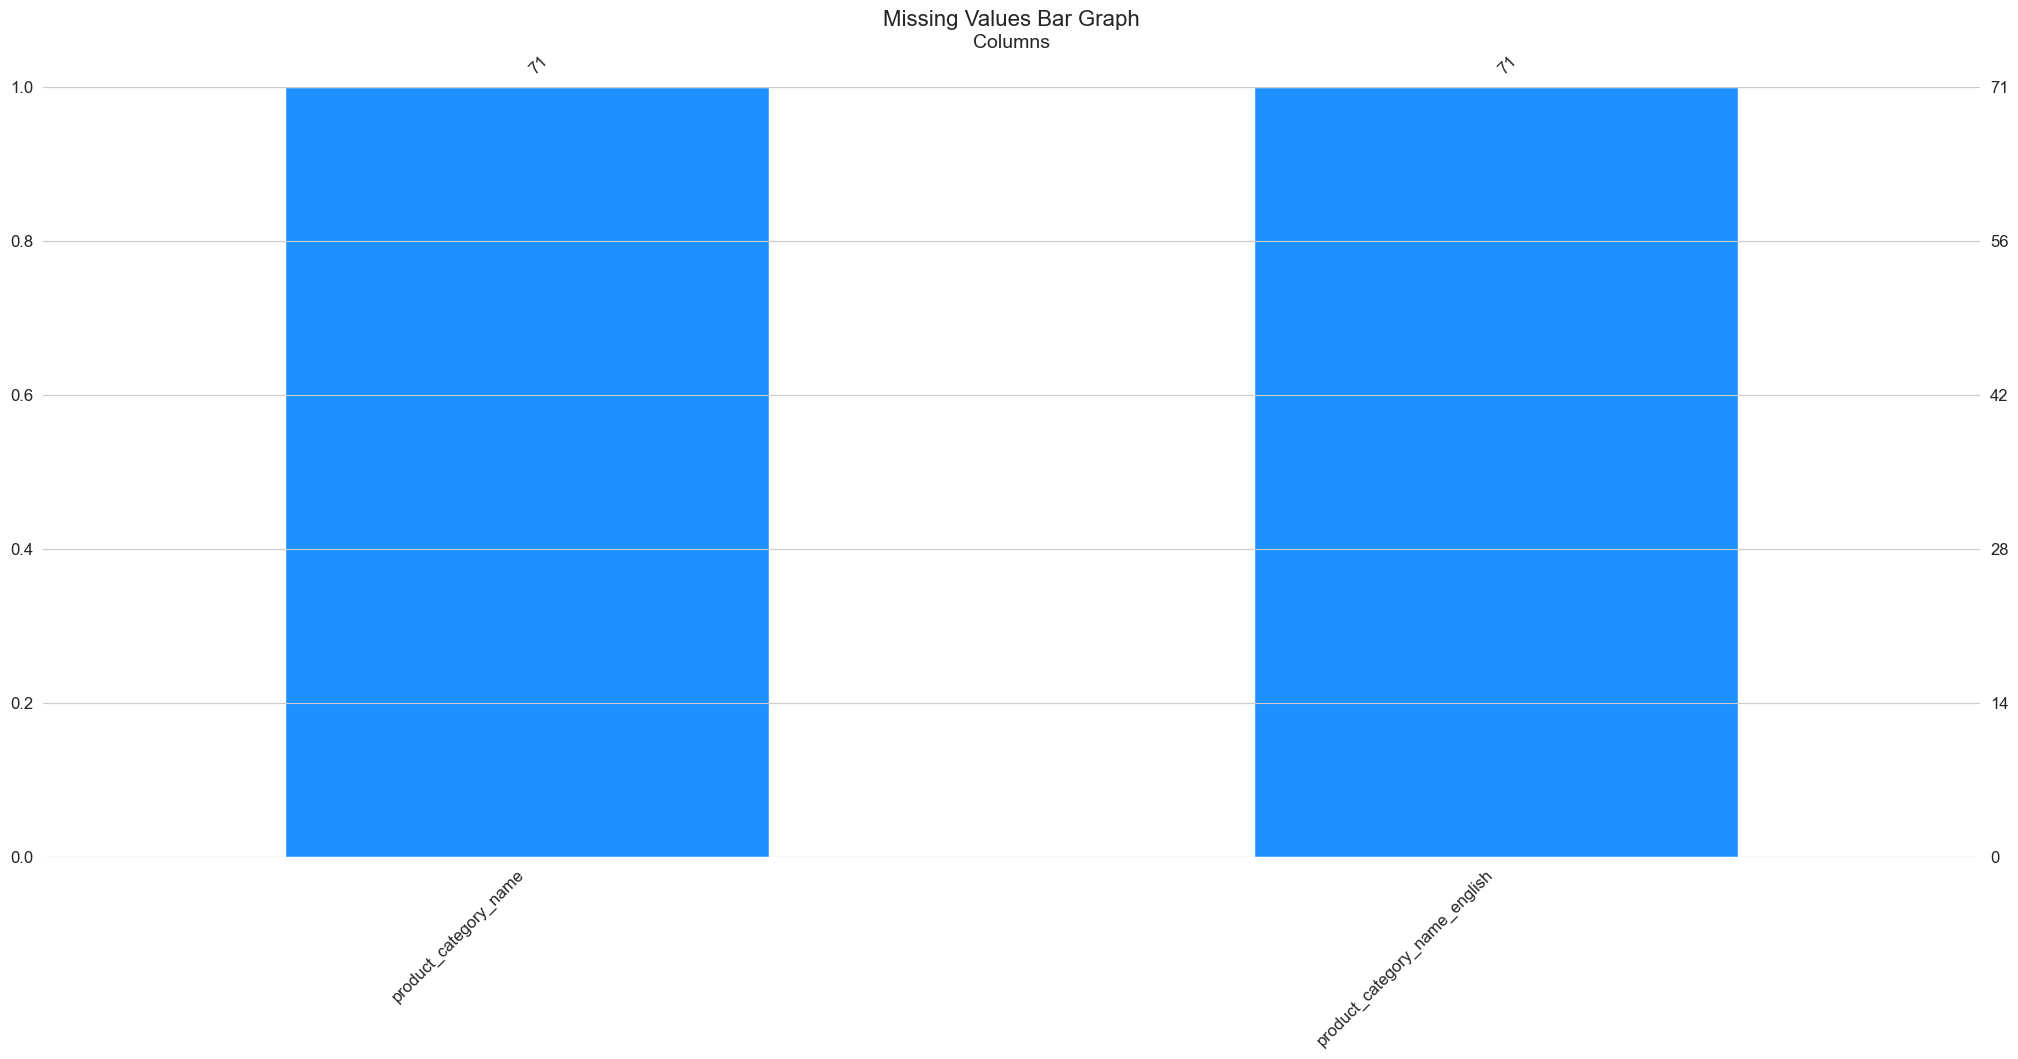

In [53]:
from fonctions import analyze_missing_data
from fonctions import generate_missingno_bar_graph

analyze_missing_data(cat)
generate_missingno_bar_graph(cat)

In [54]:
cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


# 2. Nettoyage des données

## 2.1 Jointure des dataset

Reprenons le schéma de la structure des relations des différents datasets Olist : 

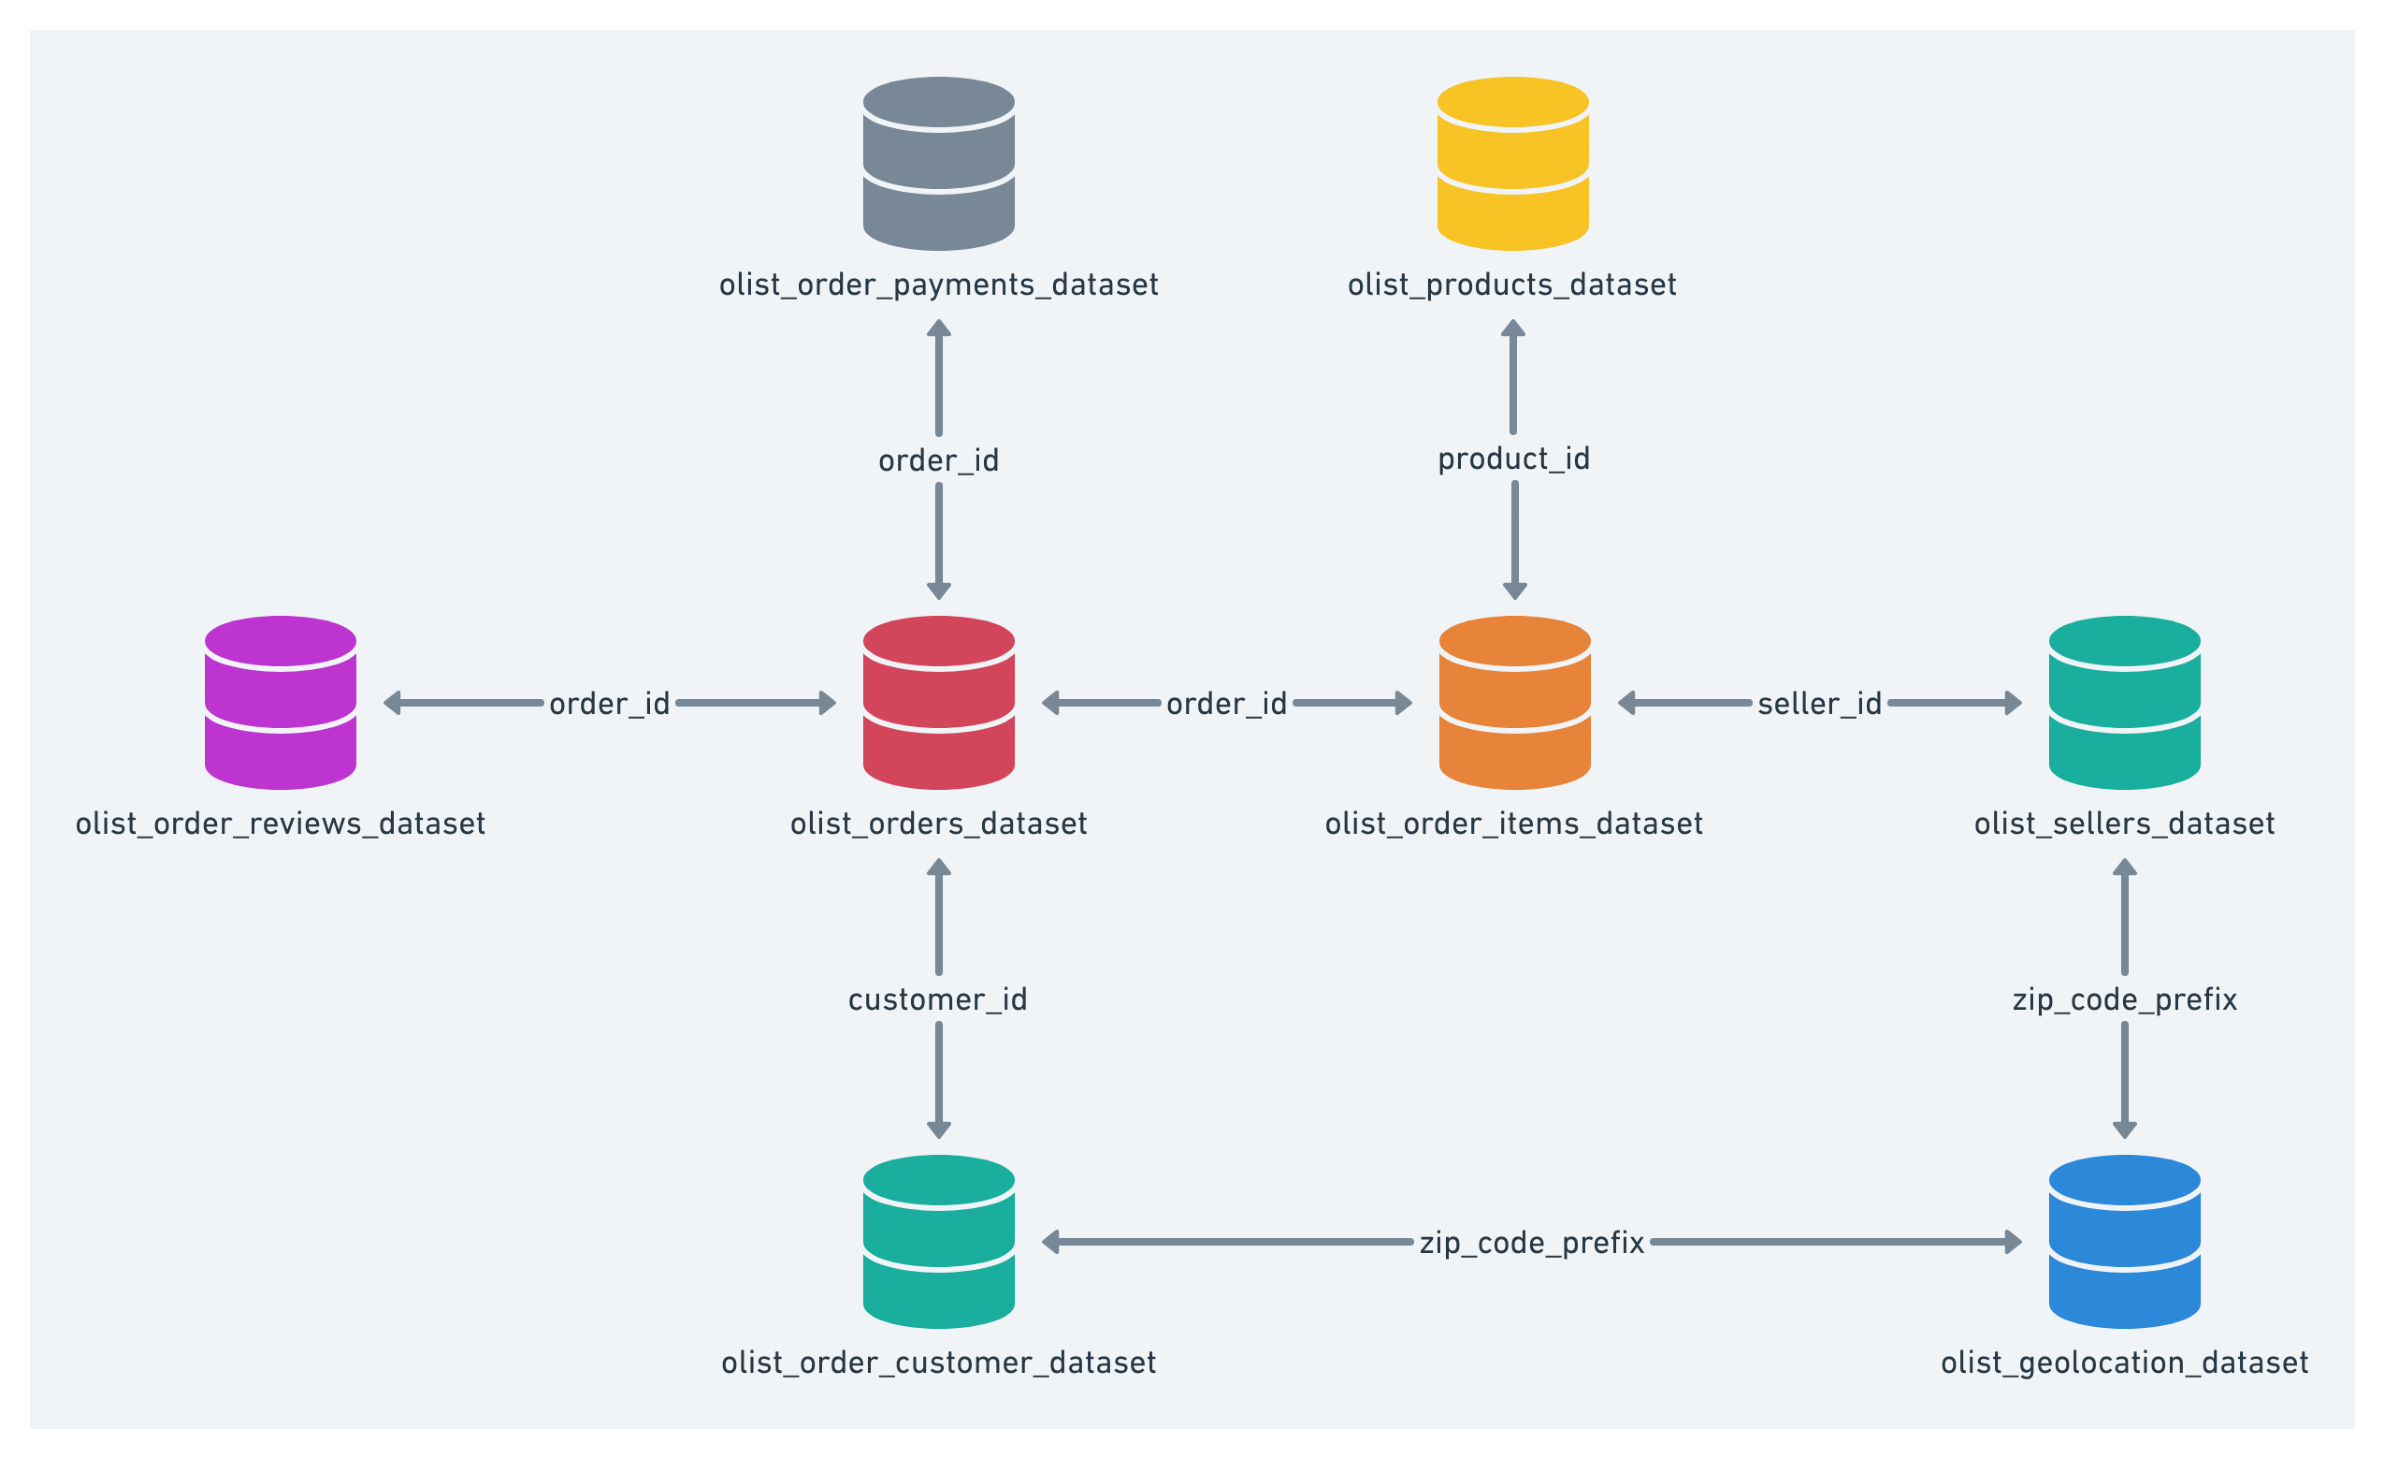

In [55]:
image = mpimg.imread('Dataset_Olist.png')

plt.figure(figsize=(10, 10), dpi=300) 
plt.imshow(image)
plt.axis('off')
plt.show()

Nous allons donc partir du dataset de base `order_id`, puis lui ajouter les différents dataset à l'aide des différentes clés.

Pour le premier, nous réalisons une jointure à droite afin de conserver les éventuelles données des clients qui ne sont pas associés à une commande.

In [56]:
data = pd.DataFrame()
data = orders.merge(cust, on='customer_id', how='right')
data = data.merge(order_items, on='order_id', how='outer')
data = data.merge(order_pay, on='order_id', how='outer')
data = data.merge(order_rev, on='order_id', how='outer')
data = data.merge(prod, on='product_id', how='outer')
data = data.merge(sell, on='seller_id', how='outer')
data = data.merge(cat, on='product_category_name', how='outer')

In [57]:
data.head()

order_id                       customer_id  \
0  00e7ee1b050b8499577073aeb2a297a1  06b8999e2fba1a1fbc88172c00ba8bc7   
1  c1d2b34febe9cd269e378117d6681172  8912fc0c3bbf1e2fbf35819e21706718   
2  c1d2b34febe9cd269e378117d6681172  8912fc0c3bbf1e2fbf35819e21706718   
3  b1a5d5365d330d10485e0203d54ab9e8  f0ac8e5a239118859b1734e1087cbb1f   
4  2e604b3614664aa66867856dba7e61b7  6bc8d08963a135220ed6c6d098831f84   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-05-16 15:05:35  2017-05-16 15:22:12   
1    delivered      2017-11-09 00:50:13  2017-11-10 00:47:48   
2    delivered      2017-11-09 00:50:13  2017-11-10 00:47:48   
3    delivered      2017-05-07 20:11:26  2017-05-08 22:22:56   
4    delivered      2018-02-03 19:45:40  2018-02-04 22:29:19   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-05-23 10:47:57           2017-05-25 10:35:35   
1          2017-11-22 01:43:37           2017-11-28 00:09:50   
2          2017-11-22 01:43:37           2017-11-28 00:09:50   
3          2017-05-19 20:16:31           2017-05-26 09:54:04   
4          2018-02-19 18:21:47           2018-02-28 21:09:00   

  order_estimated_delivery_date                customer_unique_id  \
0           2017-06-05 00:00:00  861eff4711a542e4b93843c6dd7febb0   
1           2017-12-19 00:00:00  9eae34bbd3a474ec5d07949ca7de67c0   
2           2017-12-19 00:00:00  9eae34bbd3a474ec5d07949ca7de67c0   
3           2017-06-12 00:00:00  3c799d181c34d51f6d44bbbc563024db   
4           2018-03-22 00:00:00  23397e992b09769faf5e66f9e171a241   

   customer_zip_code_prefix  ... product_description_lenght  \
0                   14409.0  ...                     1141.0   
1                   68030.0  ...                     1141.0   
2                   68030.0  ...                     1141.0   
3                   92480.0  ...                     1141.0   
4                   25931.0  ...                     1141.0   

  product_photos_qty  product_weight_g product_length_cm product_height_cm  \
0                1.0            8683.0              54.0              64.0   
1                1.0            8683.0              54.0              64.0   
2                1.0            8683.0              54.0              64.0   
3                1.0            8683.0              54.0              64.0   
4                1.0            8683.0              54.0              64.0   

  product_width_cm  seller_zip_code_prefix      seller_city  seller_state  \
0             31.0                  8577.0  itaquaquecetuba            SP   
1             31.0                  8577.0  itaquaquecetuba            SP   
2             31.0                  8577.0  itaquaquecetuba            SP   
3             31.0                  8577.0  itaquaquecetuba            SP   
4             31.0                  8577.0  itaquaquecetuba            SP   

  product_category_name_english  
0              office_furniture  
1              office_furniture  
2              office_furniture  
3              office_furniture  
4              office_furniture  

[5 rows x 40 columns]

L'objectif principal de ces jointures est de consolider toutes les informations pertinentes sur les **commandes**, les **clients** `cust`, les **articles** `order_items`, les **paiements** `order_pay`, les **avis** `order_rev`, les **produits** `prod`, les **vendeurs** `sell` et  les **catégories de produits** `cat` (bien que cat ne soit pas explicitement montré dans le diagramme) en une seule table large. 

Cela permet d'avoir une vue holistique des données e-commerce d'Olist.

In [58]:
data.shape

(119918, 40)

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119918 entries, 0 to 119917
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       119143 non-null  object 
 1   customer_id                    119085 non-null  object 
 2   order_status                   118310 non-null  object 
 3   order_purchase_timestamp       118310 non-null  object 
 4   order_approved_at              118295 non-null  object 
 5   order_delivered_carrier_date   117056 non-null  object 
 6   order_delivered_customer_date  115722 non-null  object 
 7   order_estimated_delivery_date  118310 non-null  object 
 8   customer_unique_id             119085 non-null  object 
 9   customer_zip_code_prefix       119085 non-null  float64
 10  customer_city                  119085 non-null  object 
 11  customer_state                 119085 non-null  object 
 12  order_item_id                 

In [60]:
data.describe()

customer_zip_code_prefix  order_item_id          price  freight_value  \
count             119085.000000  118310.000000  118310.000000  118310.000000   
mean               35035.069547       1.196543     120.646603      20.032387   
std                29823.674890       0.699489     184.109691      15.836850   
min                 1003.000000       1.000000       0.850000       0.000000   
25%                11250.000000       1.000000      39.900000      13.080000   
50%                24240.000000       1.000000      74.900000      16.280000   
75%                58489.000000       1.000000     134.900000      21.180000   
max                99990.000000      21.000000    6735.000000     409.680000   

       payment_sequential  payment_installments  payment_value   review_score  \
count       119140.000000         119140.000000  119140.000000  118146.000000   
mean             1.094737              2.941246     172.735135       4.015582   
std              0.730141              2.777848     267.776077       1.400436   
min              1.000000              0.000000       0.000000       1.000000   
25%              1.000000              1.000000      60.850000       4.000000   
50%              1.000000              2.000000     108.160000       5.000000   
75%              1.000000              4.000000     189.240000       5.000000   
max             29.000000             24.000000   13664.080000       5.000000   

       product_name_lenght  product_description_lenght  product_photos_qty  \
count        116601.000000               116601.000000       116601.000000   
mean             48.767498                  785.967822            2.205161   
std              10.033540                  652.584121            1.717452   
min               5.000000                    4.000000            1.000000   
25%              42.000000                  346.000000            1.000000   
50%              52.000000                  600.000000            1.000000   
75%              57.000000                  983.000000            3.000000   
max              76.000000                 3992.000000           20.000000   

       product_weight_g  product_length_cm  product_height_cm  \
count     118290.000000      118290.000000      118290.000000   
mean        2112.250740          30.265145          16.619706   
std         3786.695111          16.189367          13.453584   
min            0.000000           7.000000           2.000000   
25%          300.000000          18.000000           8.000000   
50%          700.000000          25.000000          13.000000   
75%         1800.000000          38.000000          20.000000   
max        40425.000000         105.000000         105.000000   

       product_width_cm  seller_zip_code_prefix  
count     118290.000000           118310.000000  
mean          23.074799            24442.410413  
std           11.749139            27573.004511  
min            6.000000             1001.000000  
25%           15.000000             6429.000000  
50%           20.000000            13660.000000  
75%           30.000000            27972.000000  
max          118.000000            99730.000000

## 2.2 Nettoyage des données

Tout d'abord, vérifions si nous avons des commandes dupliquées (lignes)

In [61]:
display(data[data.duplicated(keep=False)].head(10))
print("Nombre de commandes dupliquées : ", data[data.duplicated()].shape[0])

Empty DataFrame
Columns: [order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value, payment_sequential, payment_type, payment_installments, payment_value, review_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm, seller_zip_code_prefix, seller_city, seller_state, product_category_name_english]
Index: []

[0 rows x 40 columns]

Nombre de commandes dupliquées :  0


Filtrons le statut des commandes étant livrées sur `'delivered'`

In [62]:
data['order_status'].value_counts()

delivered      115723
shipped          1255
canceled          570
invoiced          376
processing        376
unavailable         7
approved            3
Name: order_status, dtype: int64

In [63]:
data = data[data['order_status'] == 'delivered']

Pour la suite du projet, il est pertinent de conserver cette vue filtrée. 

Nous allons à présent vérifier les valeurs manquantes de notre dataset : 

Nombre total de cellules manquantes : 181541
Nombre de cellules manquantes en % : 3.92%


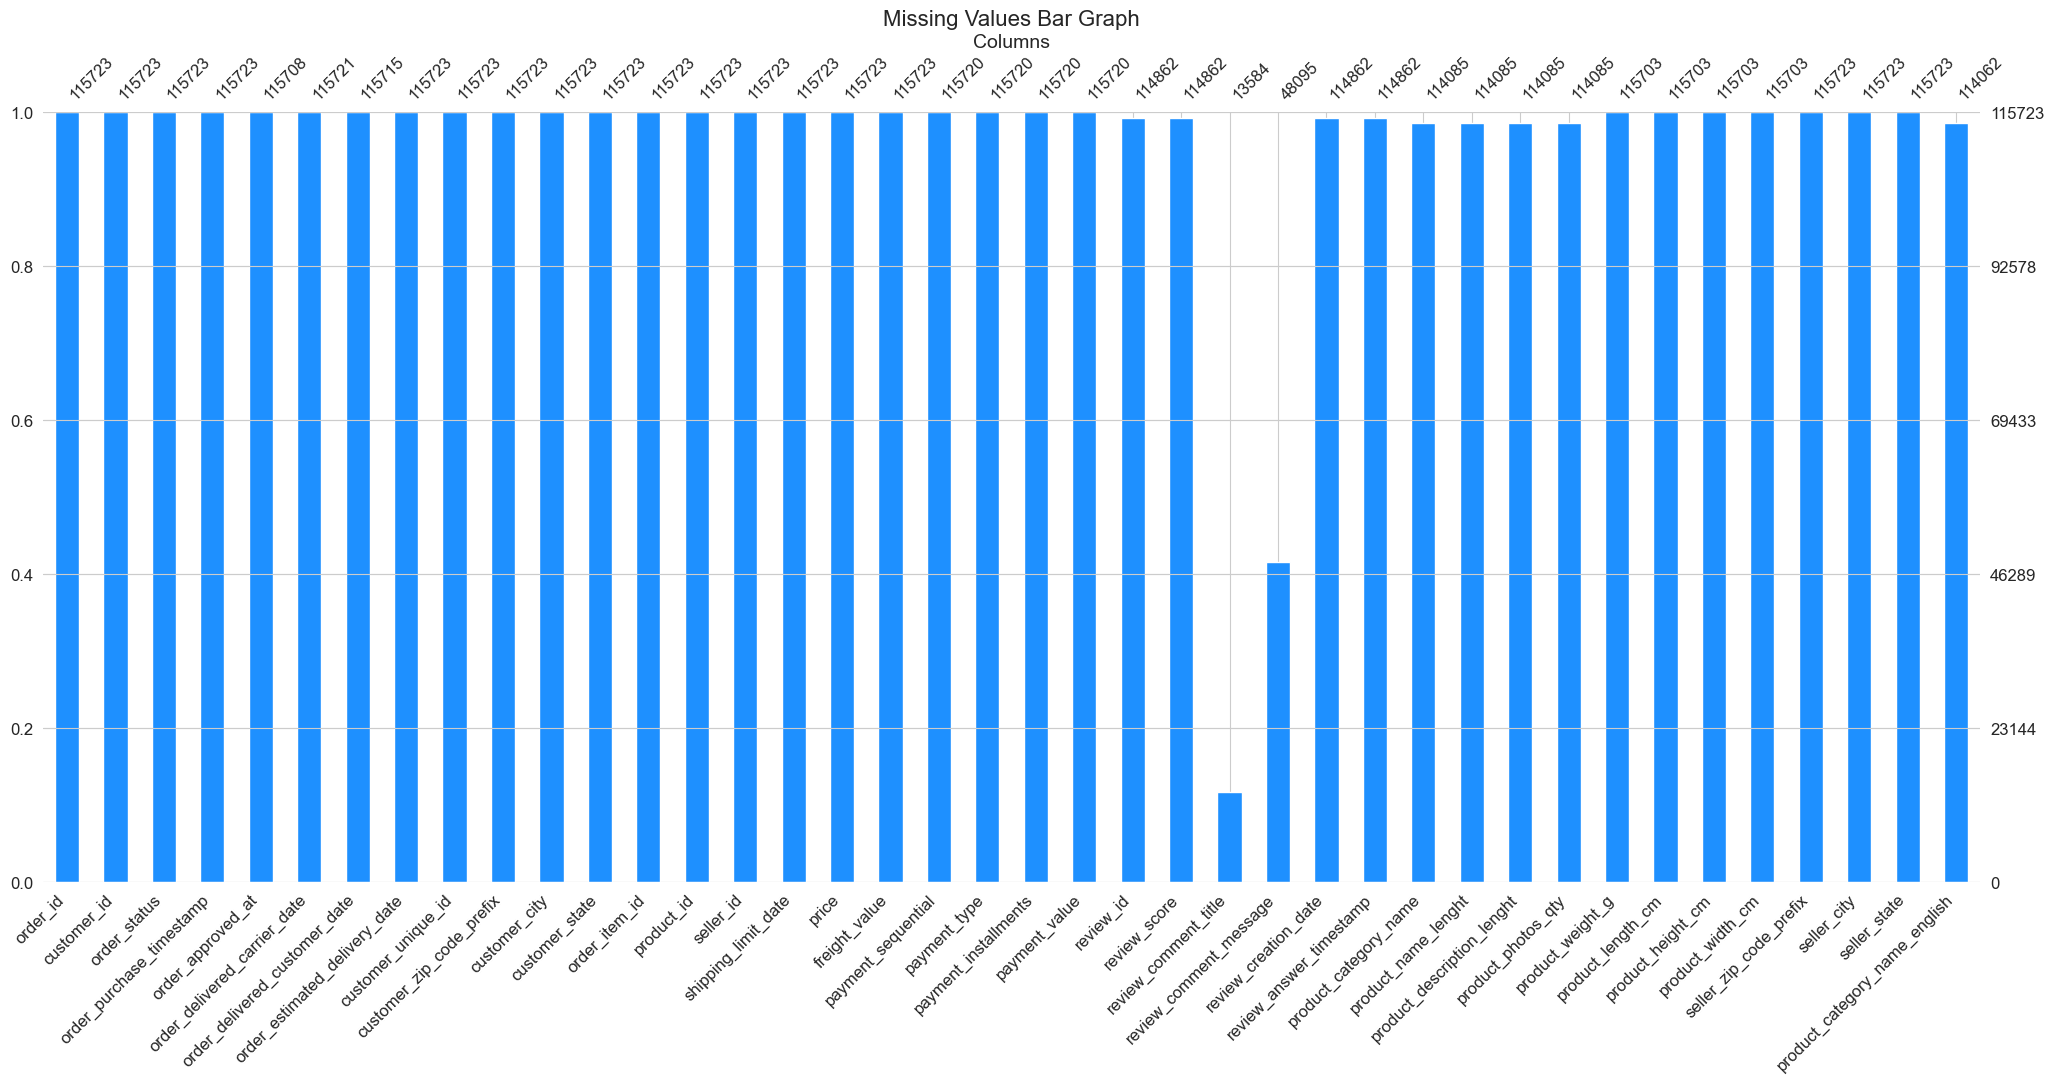

In [64]:
from fonctions import analyze_missing_data
from fonctions import generate_missingno_bar_graph

analyze_missing_data(data)
generate_missingno_bar_graph(data)

In [65]:
from fonctions import valeurs_manquantes

valeurs_manquantes(data)

Variable  Missing values  Missing (%)
0                        order_id               0     0.000000
1                     customer_id               0     0.000000
2                    order_status               0     0.000000
3        order_purchase_timestamp               0     0.000000
4               order_approved_at              15     0.000130
5    order_delivered_carrier_date               2     0.000017
6   order_delivered_customer_date               8     0.000069
7   order_estimated_delivery_date               0     0.000000
8              customer_unique_id               0     0.000000
9        customer_zip_code_prefix               0     0.000000
10                  customer_city               0     0.000000
11                 customer_state               0     0.000000
12                  order_item_id               0     0.000000
13                     product_id               0     0.000000
14                      seller_id               0     0.000000
15            shipping_limit_date               0     0.000000
16                          price               0     0.000000
17                  freight_value               0     0.000000
18             payment_sequential               3     0.000026
19                   payment_type               3     0.000026
20           payment_installments               3     0.000026
21                  payment_value               3     0.000026
22                      review_id             861     0.007440
23                   review_score             861     0.007440
24           review_comment_title          102139     0.882616
25         review_comment_message           67628     0.584395
26           review_creation_date             861     0.007440
27        review_answer_timestamp             861     0.007440
28          product_category_name            1638     0.014154
29            product_name_lenght            1638     0.014154
30     product_description_lenght            1638     0.014154
31             product_photos_qty            1638     0.014154
32               product_weight_g              20     0.000173
33              product_length_cm              20     0.000173
34              product_height_cm              20     0.000173
35               product_width_cm              20     0.000173
36         seller_zip_code_prefix               0     0.000000
37                    seller_city               0     0.000000
38                   seller_state               0     0.000000
39  product_category_name_english            1661     0.014353

Nous avons seulement 3 observations qui ne sont pas renseiggnées dans les données de paiment. Nous pouvons supprimer ces lignes

In [66]:
data = data.dropna(subset=['payment_value'])

Nous allons désormais imputer les valeurs manquantes des variables pertinentes pour la suite du projet : 

In [67]:
# Remplissage des valeurs manquantes dans les avis
data['review_score'].fillna(data['review_score'].mean(), inplace=True)
data['review_comment_title'].fillna('None', inplace=True)
data['review_comment_message'].fillna('None', inplace=True)

# Remplissage des valeurs manquantes liées au produit par 0
product_columns = [
    'product_name_lenght',
    'product_description_lenght',
    'product_photos_qty',
    'product_weight_g',
    'product_length_cm',
    'product_height_cm',
    'product_width_cm'
]

data[product_columns] = data[product_columns].fillna(0)

Traitons les valeurs manquantes des catégories de produits : 

In [68]:
data['product_category_name_english'].nunique()

71

In [69]:
data['product_category_name'].nunique()

73

Nous avons plus de catégories identifiées en portugais, donc nous pouvons nous fier à celle-ci pour identifier les valeurs manquantes en anglais : 

In [70]:
# Filtrer les lignes où la catégorie anglaise est NaN mais pas la portugaise
mask = data['product_category_name_english'].isna() & data['product_category_name'].notna()

# Extraire les catégories portugaises concernées
categories_a_traduire = data.loc[mask, 'product_category_name'].unique()

# Afficher
print("Catégories en portugais sans traduction anglaise :")
for cat in categories_a_traduire:
    print("-", cat)

Catégories en portugais sans traduction anglaise :
- pc_gamer
- portateis_cozinha_e_preparadores_de_alimentos


Traduisons directement en anglais :

In [71]:
# Dictionnaire de traductions manuelles à ajouter
traductions_manuelles = {
    'pc_gamer': 'gamer_pc',
    'portateis_cozinha_e_preparadores_de_alimentos': 'kitchen_appliances_and_food_preparers'
}

# Appliquer les traductions manuelles quand possible
for pt_cat, en_cat in traductions_manuelles.items():
    mask = (data['product_category_name'] == pt_cat) & (data['product_category_name_english'].isna())
    data.loc[mask, 'product_category_name_english'] = en_cat

# Remplir les NaN anglais par la catégorie portugaise (quand portugaise existe)
mask_nan_anglais = data['product_category_name_english'].isna()
mask_portugais_existe = data['product_category_name'].notna()

data.loc[mask_nan_anglais & mask_portugais_existe, 'product_category_name_english'] = \
    data.loc[mask_nan_anglais & mask_portugais_existe, 'product_category_name']

# Pour les cas où les deux colonnes sont NaN, remplacer par 'uncategorized'
mask_both_nan = data['product_category_name_english'].isna() & data['product_category_name'].isna()
data.loc[mask_both_nan, 'product_category_name_english'] = 'uncategorized'

In [72]:
from fonctions import valeurs_manquantes

valeurs_manquantes(data)

Variable  Missing values  Missing (%)
0                        order_id               0     0.000000
1                     customer_id               0     0.000000
2                    order_status               0     0.000000
3        order_purchase_timestamp               0     0.000000
4               order_approved_at              15     0.000130
5    order_delivered_carrier_date               2     0.000017
6   order_delivered_customer_date               8     0.000069
7   order_estimated_delivery_date               0     0.000000
8              customer_unique_id               0     0.000000
9        customer_zip_code_prefix               0     0.000000
10                  customer_city               0     0.000000
11                 customer_state               0     0.000000
12                  order_item_id               0     0.000000
13                     product_id               0     0.000000
14                      seller_id               0     0.000000
15            shipping_limit_date               0     0.000000
16                          price               0     0.000000
17                  freight_value               0     0.000000
18             payment_sequential               0     0.000000
19                   payment_type               0     0.000000
20           payment_installments               0     0.000000
21                  payment_value               0     0.000000
22                      review_id             861     0.007440
23                   review_score               0     0.000000
24           review_comment_title               0     0.000000
25         review_comment_message               0     0.000000
26           review_creation_date             861     0.007440
27        review_answer_timestamp             861     0.007440
28          product_category_name            1638     0.014155
29            product_name_lenght               0     0.000000
30     product_description_lenght               0     0.000000
31             product_photos_qty               0     0.000000
32               product_weight_g               0     0.000000
33              product_length_cm               0     0.000000
34              product_height_cm               0     0.000000
35               product_width_cm               0     0.000000
36         seller_zip_code_prefix               0     0.000000
37                    seller_city               0     0.000000
38                   seller_state               0     0.000000
39  product_category_name_english               0     0.000000

In [73]:
data.dtypes

order_id                          object
customer_id                       object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
customer_unique_id                object
customer_zip_code_prefix         float64
customer_city                     object
customer_state                    object
order_item_id                    float64
product_id                        object
seller_id                         object
shipping_limit_date               object
price                            float64
freight_value                    float64
payment_sequential               float64
payment_type                      object
payment_installments             float64
payment_value                    float64
review_id                         object
review_score                     float64
review_comment_t

Nous allons modifier les types des colonnes : 

In [74]:
cols_to_datetime = [
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_purchase_timestamp',
    'order_delivered_customer_date',
    'shipping_limit_date',
    'order_estimated_delivery_date',
    'review_creation_date',
    'review_answer_timestamp'
]

for col in cols_to_datetime:
    data[col] = pd.to_datetime(data[col], errors='coerce')


In [75]:
# Colonnes à convertir en category
category_cols = [
    'order_id',
    'customer_id',
    'order_status',
    'customer_unique_id',
    'customer_city',
    'customer_state',
    'product_id',
    'seller_id',
    'payment_type',
    'review_id',
    'review_comment_title',
    'review_comment_message',
    'product_category_name',
    'seller_city',
    'seller_state',
    'product_category_name_english'
]

# Conversion des colonnes en category
for col in category_cols:
    data[col] = data[col].astype('category')

In [76]:
data.dtypes

order_id                               category
customer_id                            category
order_status                           category
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
customer_unique_id                     category
customer_zip_code_prefix                float64
customer_city                          category
customer_state                         category
order_item_id                           float64
product_id                             category
seller_id                              category
shipping_limit_date              datetime64[ns]
price                                   float64
freight_value                           float64
payment_sequential                      float64
payment_type                           category
payment_installments                    

In [77]:
data.shape

(115720, 40)

In [78]:
data.to_csv('data_cleaned_all.csv', index=False)
data = pd.read_csv('data_cleaned_all.csv')

Nombre total de cellules manquantes : 4246
Nombre de cellules manquantes en % : 0.09%


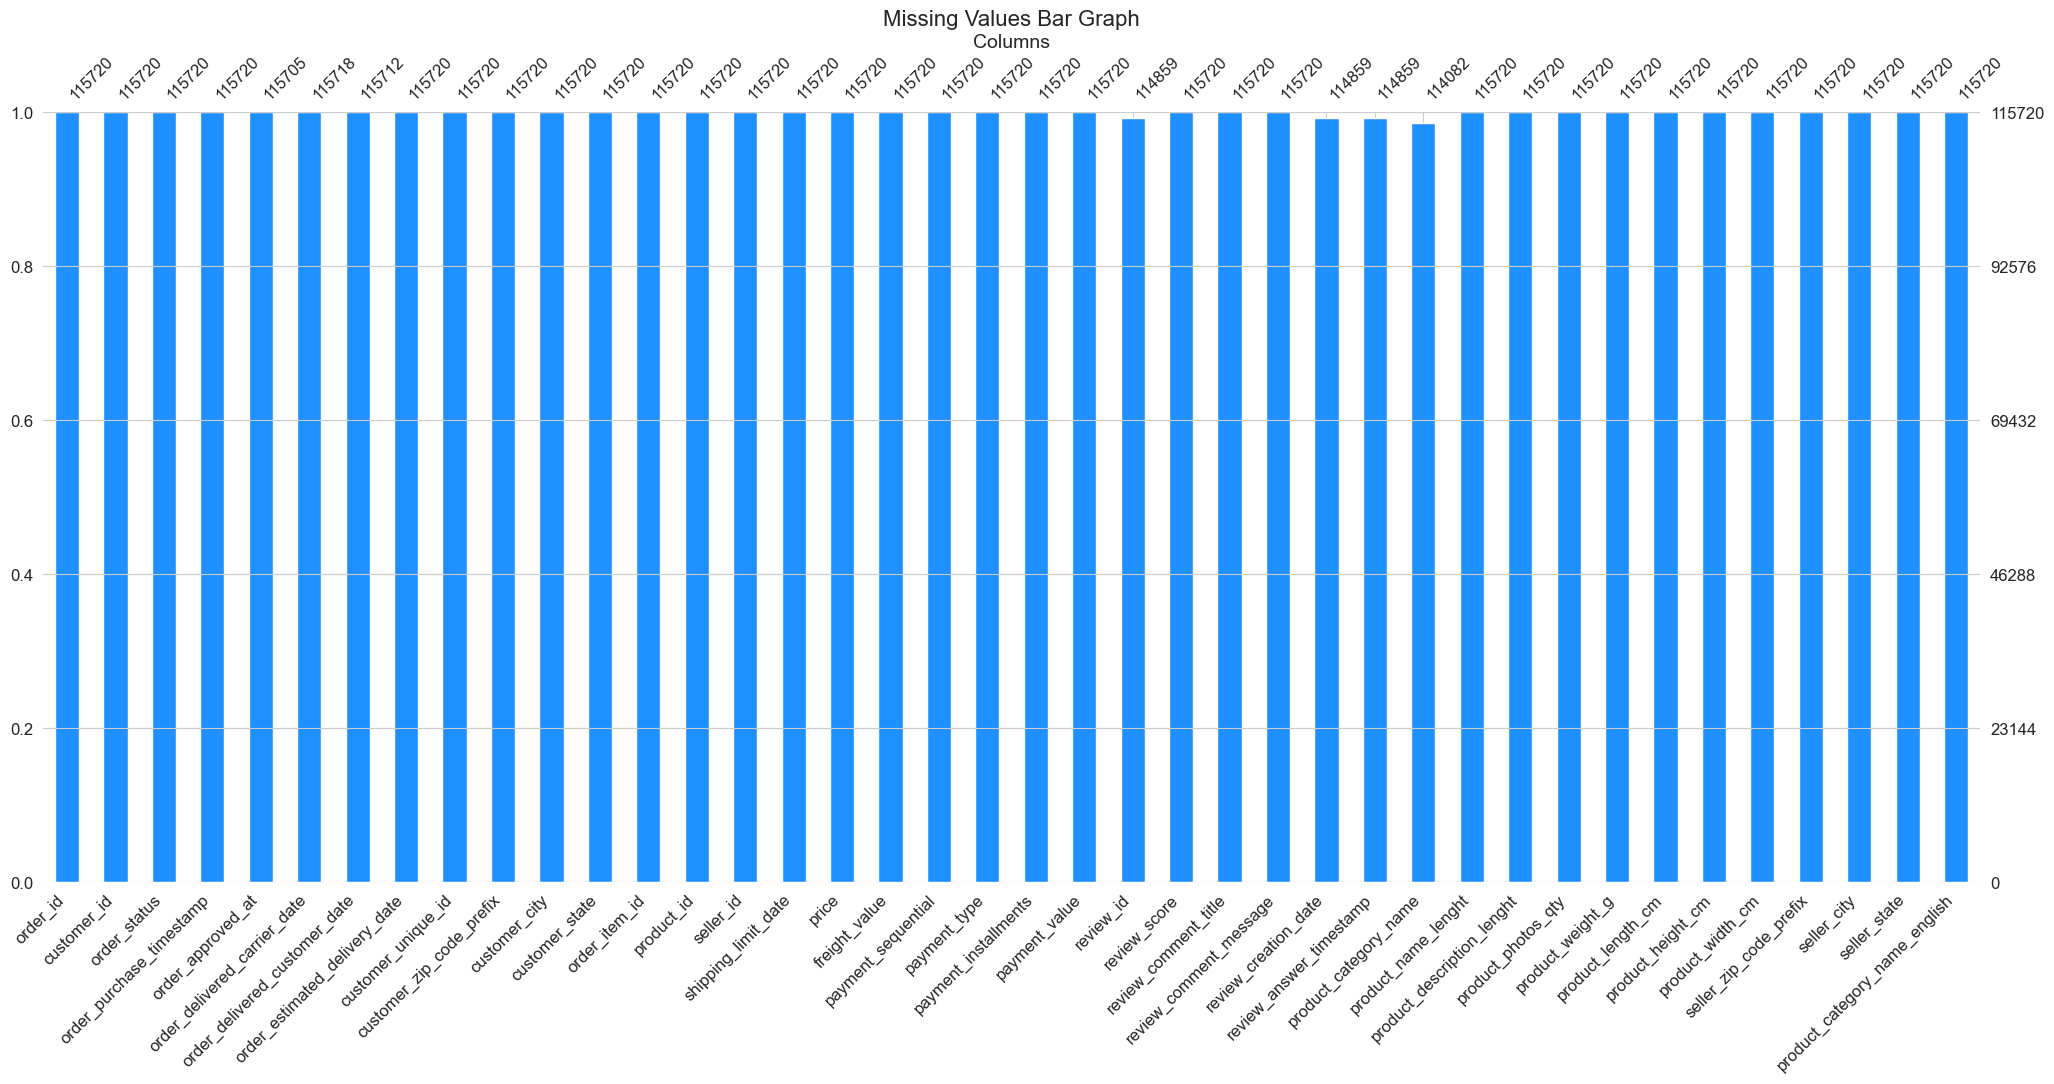

In [79]:
from fonctions import analyze_missing_data
from fonctions import generate_missingno_bar_graph

analyze_missing_data(data)
generate_missingno_bar_graph(data)

## 2.3 Création du dataset clients aggrégé

In [80]:
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'], errors='coerce')

# Récupération de la date maximale (la plus récente) dans la colonne
date_max = data['order_purchase_timestamp'].max()

# Récupération de la date minimale (la plus ancienne) dans la colonne
date_min = data['order_purchase_timestamp'].min()

# Affichage de la période couverte par le dataset en jours
print('Le data set va de {} à {}, soit {} jours.'
      .format(date_min,           # date de début
              date_max,           # date de fin
              (date_max - date_min).days))  # nombre de jours entre les deux dates

Le data set va de 2016-10-03 09:44:50 à 2018-08-29 15:00:37, soit 695 jours.


In [81]:
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])
data['order_delivered_customer_date'] = pd.to_datetime(data['order_delivered_customer_date'])
data['order_estimated_delivery_date'] = pd.to_datetime(data['order_estimated_delivery_date'])

In [82]:
from fonctions import df_agg_cust

data_cust = df_agg_cust(data)

In [83]:
data_cust.head()

order_purchase_timestamp  \
customer_unique_id                                          
0000366f3b9a7992bf8c76cfdf3221e2      2018-05-10 10:56:27   
0000b849f77a49e4a4ce2b2a4ca5be3f      2018-05-07 11:11:27   
0000f46a3911fa3c0805444483337064      2017-03-10 21:05:03   
0000f6ccb0745a6a4b88665a16c9f078      2017-10-12 20:29:41   
0004aac84e0df4da2b147fca70cf8255      2017-11-14 19:45:42   

                                 order_delivered_customer_date  \
customer_unique_id                                               
0000366f3b9a7992bf8c76cfdf3221e2           2018-05-16 20:48:37   
0000b849f77a49e4a4ce2b2a4ca5be3f           2018-05-10 18:02:42   
0000f46a3911fa3c0805444483337064           2017-04-05 14:38:47   
0000f6ccb0745a6a4b88665a16c9f078           2017-11-01 21:23:05   
0004aac84e0df4da2b147fca70cf8255           2017-11-27 23:08:56   

                                 order_estimated_delivery_date  \
customer_unique_id                                               
0000366f3b9a7992bf8c76cfdf3221e2                    2018-05-21   
0000b849f77a49e4a4ce2b2a4ca5be3f                    2018-05-15   
0000f46a3911fa3c0805444483337064                    2017-04-07   
0000f6ccb0745a6a4b88665a16c9f078                    2017-11-13   
0004aac84e0df4da2b147fca70cf8255                    2017-12-05   

                                  time_since_first_order  \
customer_unique_id                                         
0000366f3b9a7992bf8c76cfdf3221e2                     111   
0000b849f77a49e4a4ce2b2a4ca5be3f                     114   
0000f46a3911fa3c0805444483337064                     536   
0000f6ccb0745a6a4b88665a16c9f078                     320   
0004aac84e0df4da2b147fca70cf8255                     287   

                                  time_since_last_order customer_city  \
customer_unique_id                                                      
0000366f3b9a7992bf8c76cfdf3221e2                    111       cajamar   
0000b849f77a49e4a4ce2b2a4ca5be3f                    114        osasco   
0000f46a3911fa3c0805444483337064                    536      sao jose   
0000f6ccb0745a6a4b88665a16c9f078                    320         belem   
0004aac84e0df4da2b147fca70cf8255                    287      sorocaba   

                                 customer_state  nb_total_order  \
customer_unique_id                                                
0000366f3b9a7992bf8c76cfdf3221e2             SP               1   
0000b849f77a49e4a4ce2b2a4ca5be3f             SP               1   
0000f46a3911fa3c0805444483337064             SC               1   
0000f6ccb0745a6a4b88665a16c9f078             PA               1   
0004aac84e0df4da2b147fca70cf8255             SP               1   

                                  nb_total_item  total_price  mean_price  \
customer_unique_id                                                         
0000366f3b9a7992bf8c76cfdf3221e2              1       129.90      129.90   
0000b849f77a49e4a4ce2b2a4ca5be3f              1        18.90       18.90   
0000f46a3911fa3c0805444483337064              1        69.00       69.00   
0000f6ccb0745a6a4b88665a16c9f078              1        25.99       25.99   
0004aac84e0df4da2b147fca70cf8255              1       180.00      180.00   

                                 payment_type  mean_review_score  \
customer_unique_id                                                 
0000366f3b9a7992bf8c76cfdf3221e2  credit_card                5.0   
0000b849f77a49e4a4ce2b2a4ca5be3f  credit_card                4.0   
0000f46a3911fa3c0805444483337064  credit_card                3.0   
0000f6ccb0745a6a4b88665a16c9f078  credit_card                4.0   
0004aac84e0df4da2b147fca70cf8255  credit_card                5.0   

                                           seller_city seller_state  \
customer_unique_id                                                    
0000366f3b9a7992bf8c76cfdf3221e2            piracicaba           SP   
0000b849f77a49e4a4ce2b2a4ca5be3f             sao paul

In [84]:
data_cust.to_csv('data_customers.csv')

# 3. Analyse exploratoire des données

In [85]:
data_cust.shape

(93357, 16)

In [86]:
data_cust.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93357 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_purchase_timestamp       93357 non-null  datetime64[ns]
 1   order_delivered_customer_date  93349 non-null  datetime64[ns]
 2   order_estimated_delivery_date  93357 non-null  datetime64[ns]
 3   time_since_first_order         93357 non-null  int64         
 4   time_since_last_order          93357 non-null  int64         
 5   customer_city                  93357 non-null  object        
 6   customer_state                 93357 non-null  object        
 7   nb_total_order                 93357 non-null  int64         
 8   nb_total_item                  93357 non-null  int64         
 9   total_price                    93357 non-null  float64       
 10  mean_price                   

In [87]:
data_cust.describe()

time_since_first_order  time_since_last_order  nb_total_order  \
count            93357.000000           93357.000000    93357.000000   
mean               239.581852             236.936673        1.239543   
std                153.092611             152.584315        0.849057   
min                  0.000000               0.000000        1.000000   
25%                116.000000             113.000000        1.000000   
50%                221.000000             218.000000        1.000000   
75%                349.000000             345.000000        1.000000   
max                695.000000             694.000000       75.000000   

       nb_total_item   total_price    mean_price  mean_review_score  
count   93357.000000  93357.000000  93357.000000       93357.000000  
mean        1.239543    148.637347    125.835110           4.152996  
std         0.849057    245.405174    190.541768           1.276137  
min         1.000000      0.850000      0.850000           1.000000  
25%         1.000000     48.900000     42.900000           4.000000  
50%         1.000000     89.900000     79.000000           5.000000  
75%         1.000000    159.900000    139.900000           5.000000  
max        75.000000  13440.000000   6735.000000           5.000000

In [88]:
# Sélectionner toutes les colonnes numériques (entiers et flottants) dans data_cust
col_quanti = data_cust.select_dtypes(['int64', 'float64']).columns

# Sélectionner toutes les colonnes qualitatives : catégories pandas, chaînes de caractères et booléens
col_quali = data_cust.select_dtypes(['category', 'object', 'bool']).columns

# Sélectionner toutes les colonnes de type datetime (dates et horodatages)
col_date = data_cust.select_dtypes(['datetime64[ns]']).columns

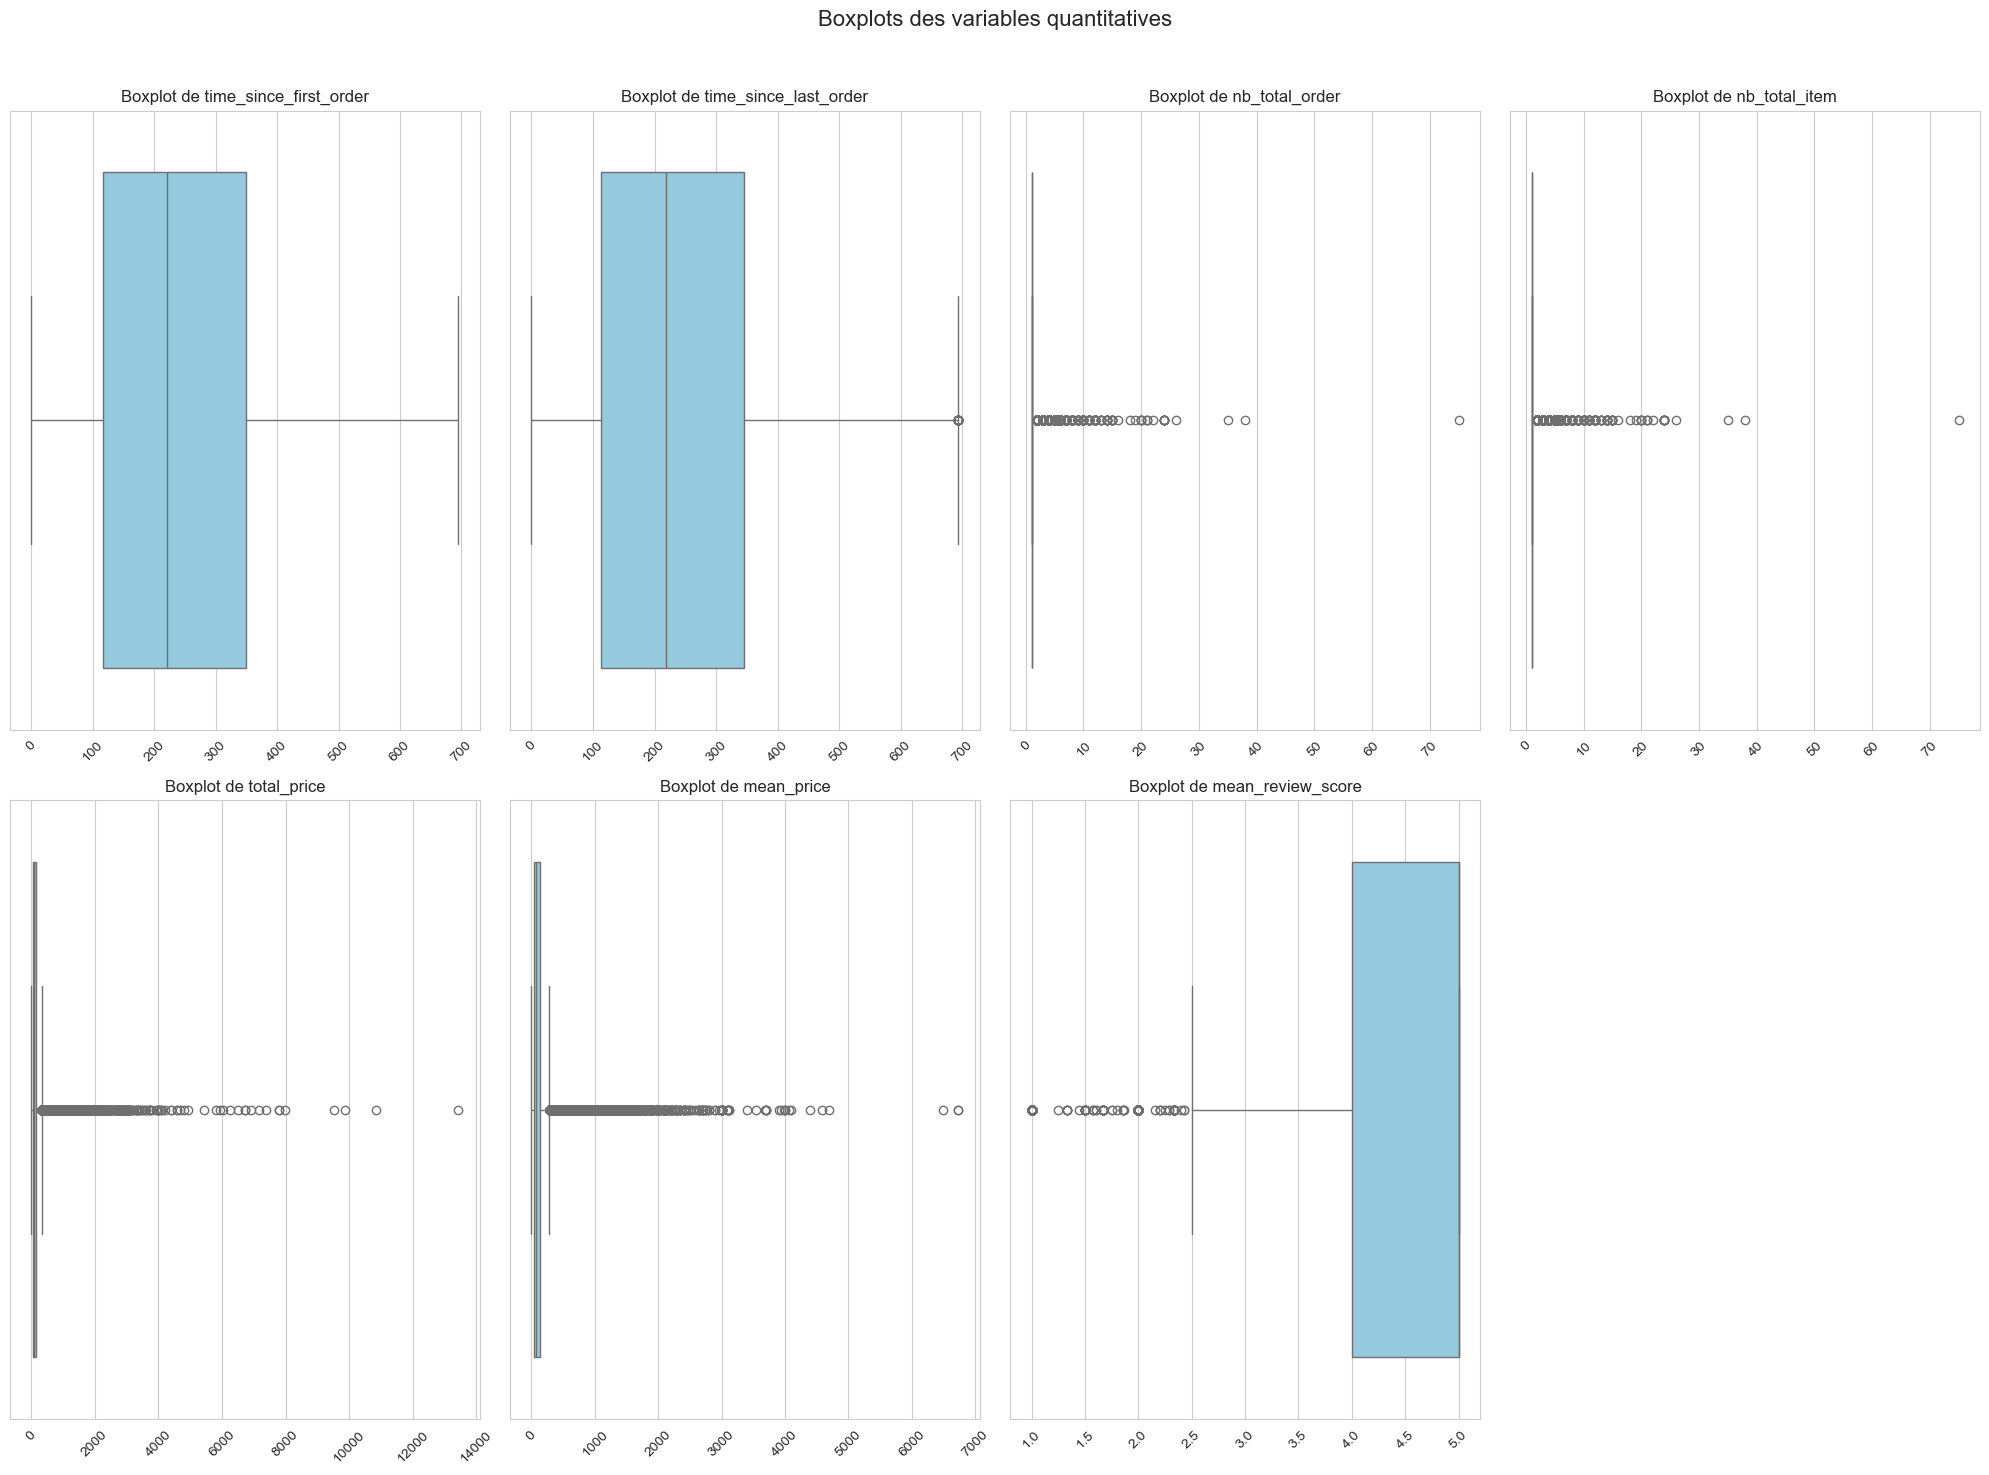

In [89]:
from fonctions import plot_multiple_boxplots

plot_multiple_boxplots(data_cust[col_quanti], n_cols=4, figsize=(20,15))

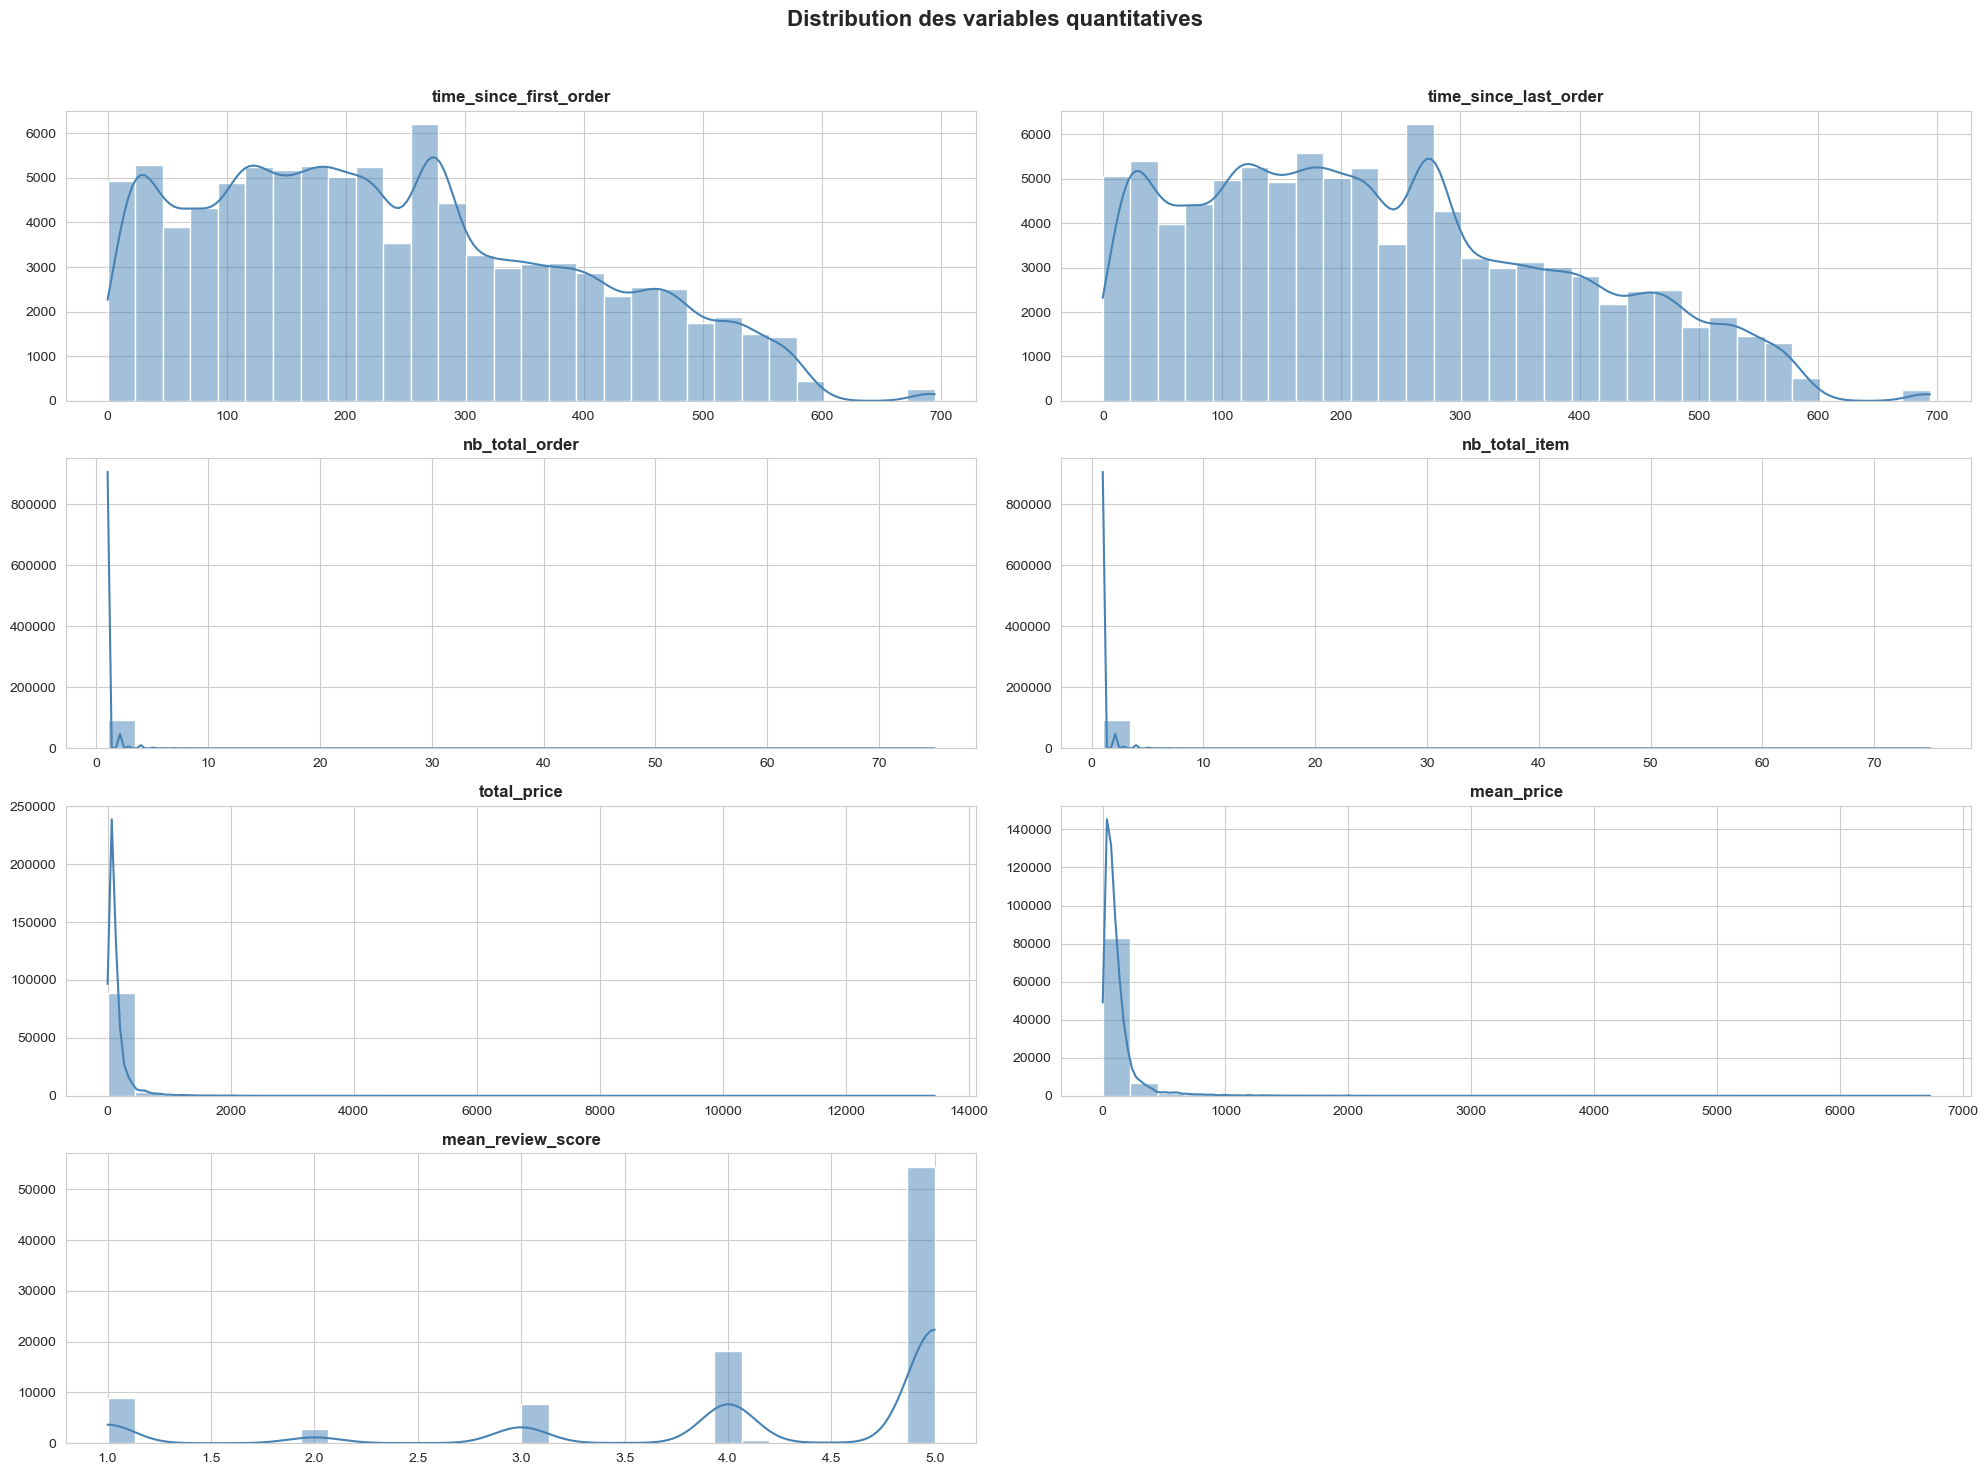

In [90]:
from fonctions import distribution_barplots

distribution_barplots(data_cust, col_quanti, ncols=4, figsize=(20, 15))

La plupart des variables sont concentrées autour de certaines valeurs.

In [91]:
from fonctions import test_normalite

# Appel de la fonction de test de normalité pour les colonnes quantitatives
resultats = test_normalite(data_cust, list(col_quanti), level=0.05)
display(resultats)

Variable Shapiro p-val  Normaltest p-val  Anderson stat  \
0  time_since_first_order      N > 5000               0.0     858.187462   
1   time_since_last_order      N > 5000               0.0     885.172040   
2          nb_total_order      N > 5000               0.0   23152.304069   
3           nb_total_item      N > 5000               0.0   23152.304069   
4             total_price      N > 5000               0.0   12988.550140   
5              mean_price      N > 5000               0.0   12218.531721   
6       mean_review_score      N > 5000               0.0   12037.485326   

   Anderson seuil 5% Normalité (Shapiro)  Normalité (Normaltest)  \
0              0.787                 N/A                   False   
1              0.787                 N/A                   False   
2              0.787                 N/A                   False   
3              0.787                 N/A                   False   
4              0.787                 N/A                   False   
5              0.787                 N/A                   False   
6              0.787                 N/A                   False   

   Normalité (Anderson)  
0                 False  
1                 False  
2                 False  
3                 False  
4                 False  
5                 False  
6                 False

Aucune des variables ne suit une distribution normale, d’après les tests D’Agostino-Pearson et Anderson-Darling.

In [92]:
import sqlite3
import pandas as pd

# Chemin vers la base SQLite
db_path = "/Users/jadesuchaud/Downloads/olist.db"

# Connexion à la base SQLite
conn = sqlite3.connect(db_path)

Top 10 des catégories de produits les plus vendus :

In [93]:
query = """
SELECT 
    t.product_category_name_english AS product_category_name,  
    COUNT(oi.product_id) AS total_sold
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
JOIN translation t ON p.product_category_name = t.product_category_name
GROUP BY t.product_category_name_english
ORDER BY total_sold DESC
LIMIT 10;

"""

df = pd.read_sql(query, conn)
print(df.head())  # Aperçu des résultats

   product_category_name  total_sold
0         bed_bath_table       11115
1          health_beauty        9670
2         sports_leisure        8641
3        furniture_decor        8334
4  computers_accessories        7827


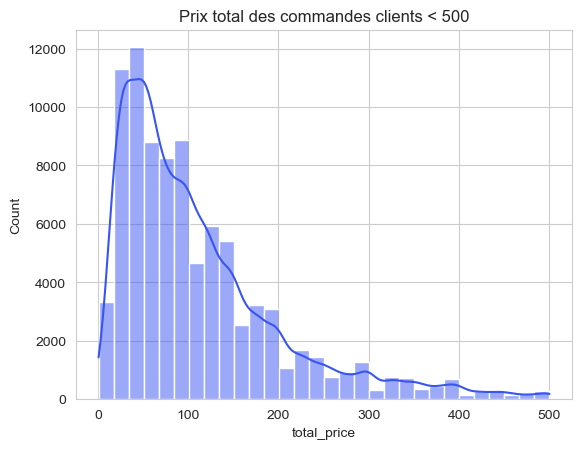

In [95]:
filtered = data_cust[data_cust['total_price'] < 500]
sns.histplot(filtered['total_price'], bins=30, kde=True)
plt.title('Prix total des commandes clients < 500')
plt.show()

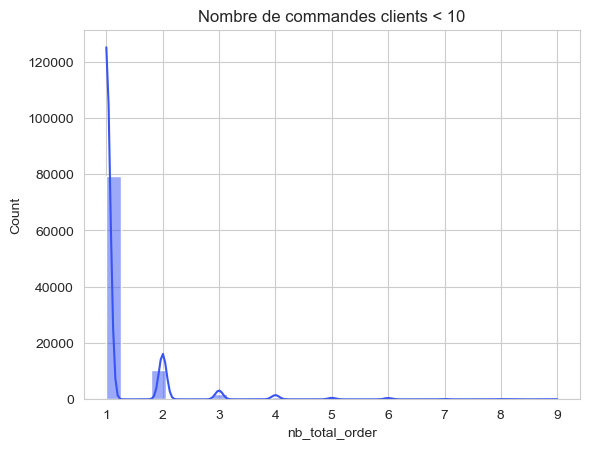

In [96]:
filtered = data_cust[data_cust['nb_total_order'] < 10]
sns.histplot(filtered['nb_total_order'], bins=30, kde=True)
plt.title('Nombre de commandes clients < 10')
plt.show()

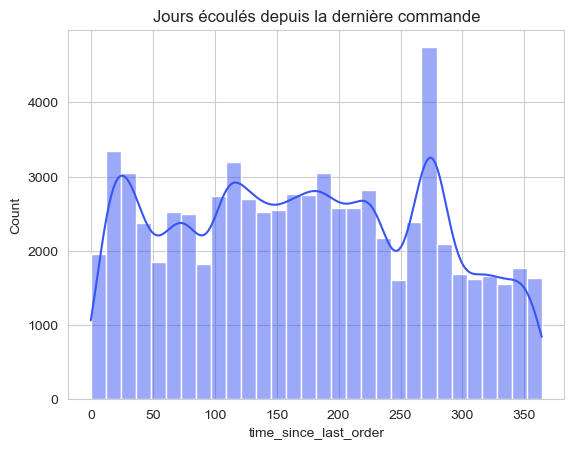

In [97]:
filtered = data_cust[data_cust['time_since_last_order'] < 365]
sns.histplot(filtered['time_since_last_order'], bins=30, kde=True)
plt.title('Jours écoulés depuis la dernière commande')
plt.show()

/var/folders/f1/6tjqbrdd3vz74bz9bkl_0bjh0000gn/T/ipykernel_4622/2257887191.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cats.values, y=top_cats.index, palette="Blues_d")  # "_d" = plus contrasté


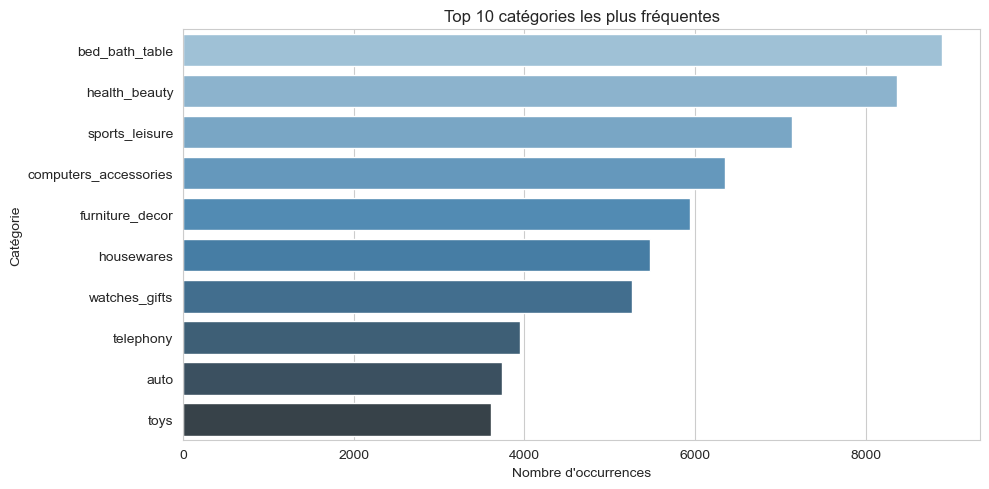

In [98]:
# Top 10 des catégories les plus fréquentes
top_cats = data_cust['cat'].value_counts().nlargest(10)

# Affichage du barplot en bleu
plt.figure(figsize=(10, 5))
sns.barplot(x=top_cats.values, y=top_cats.index, palette="Blues_d")  # "_d" = plus contrasté
plt.title("Top 10 catégories les plus fréquentes")
plt.xlabel("Nombre d'occurrences")
plt.ylabel("Catégorie")
plt.tight_layout()
plt.show()

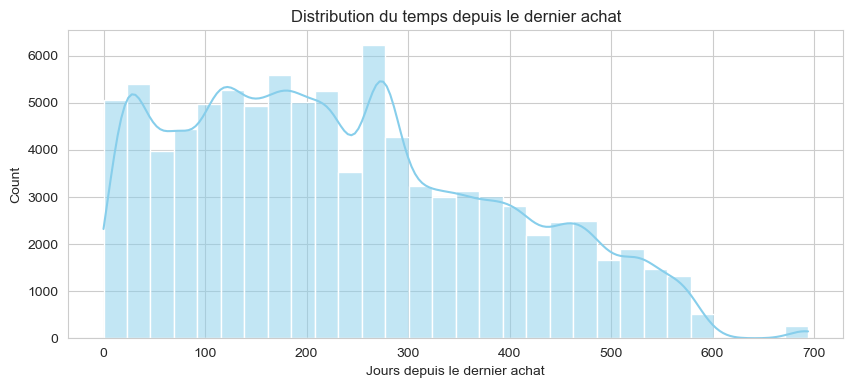

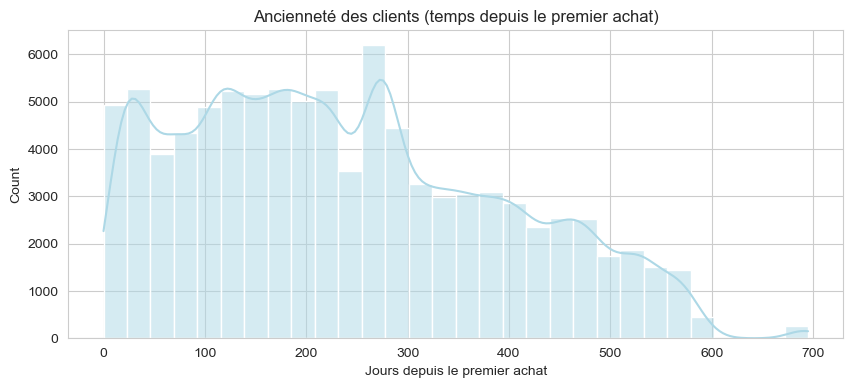

In [99]:
plt.figure(figsize=(10, 4))
sns.histplot(data_cust['time_since_last_order'], bins=30, kde=True, color="skyblue")
plt.title("Distribution du temps depuis le dernier achat")
plt.xlabel("Jours depuis le dernier achat")
plt.show()

plt.figure(figsize=(10, 4))
sns.histplot(data_cust['time_since_first_order'], bins=30, kde=True, color="lightblue")
plt.title("Ancienneté des clients (temps depuis le premier achat)")
plt.xlabel("Jours depuis le premier achat")
plt.show()

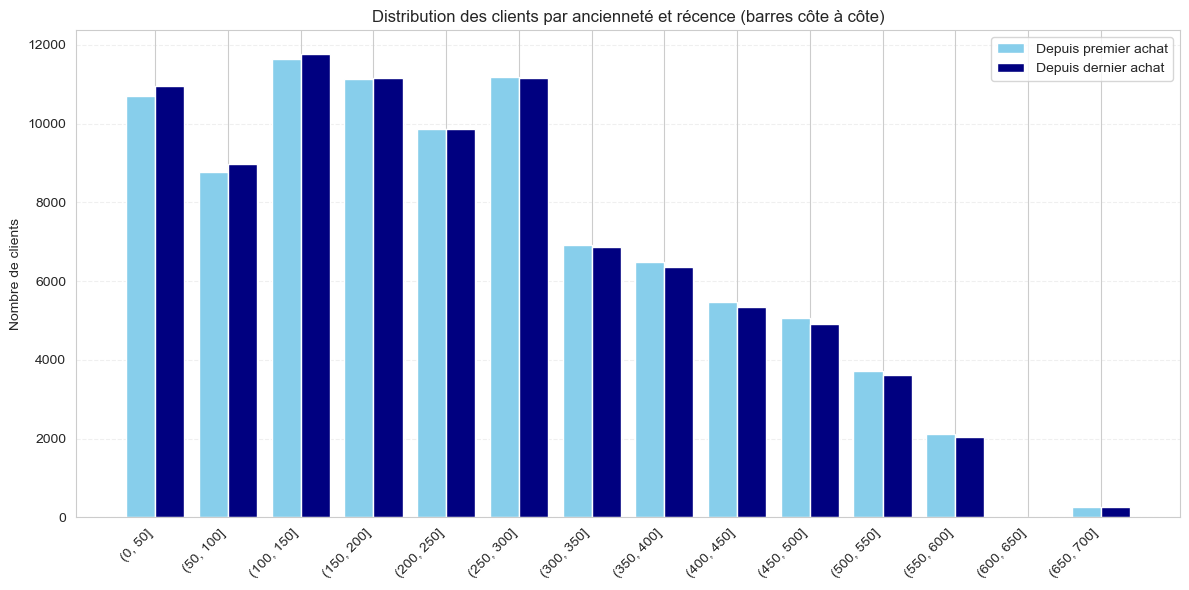

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Créer les mêmes intervalles pour les deux variables
bins = np.arange(0, max(data_cust[['time_since_first_order', 'time_since_last_order']].max()) + 50, 50)

# Discrétiser
data_cust['bin_first'] = pd.cut(data_cust['time_since_first_order'], bins=bins)
data_cust['bin_last'] = pd.cut(data_cust['time_since_last_order'], bins=bins)

# Compter les effectifs par bin
first_counts = data_cust['bin_first'].value_counts().sort_index()
last_counts = data_cust['bin_last'].value_counts().sort_index()

# Transformer en DataFrame pour aligner
hist_df = pd.DataFrame({
    'Intervalle (jours)': [str(interval) for interval in first_counts.index],
    'Depuis premier achat': first_counts.values,
    'Depuis dernier achat': last_counts.values
})

# Paramètres pour l’affichage côte à côte
x = np.arange(len(hist_df))
width = 0.4

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, hist_df['Depuis premier achat'], width=width, label='Depuis premier achat', color='skyblue')
plt.bar(x + width/2, hist_df['Depuis dernier achat'], width=width, label='Depuis dernier achat', color='navy')

plt.xticks(x, hist_df['Intervalle (jours)'], rotation=45, ha='right')
plt.ylabel("Nombre de clients")
plt.title("Distribution des clients par ancienneté et récence (barres côte à côte)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


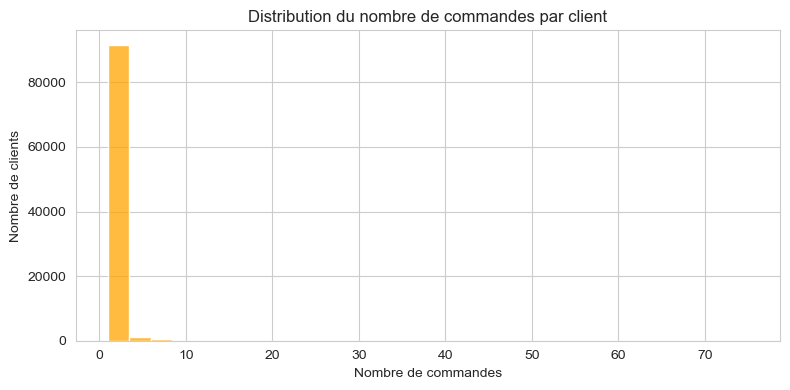

In [101]:
plt.figure(figsize=(8, 4))
sns.histplot(data_cust['nb_total_order'], bins=30, kde=False, color='orange')
plt.title("Distribution du nombre de commandes par client")
plt.xlabel("Nombre de commandes")
plt.ylabel("Nombre de clients")
plt.tight_layout()
plt.show()

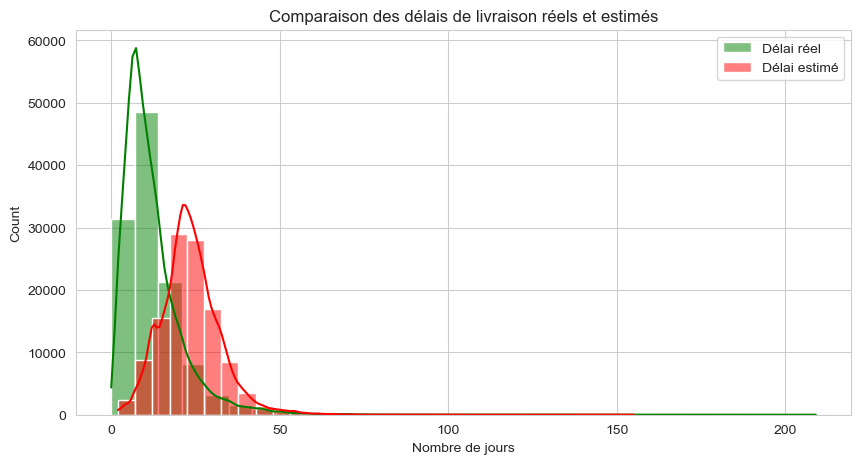

In [102]:
# Calcul du délai de livraison réel et estimé
data['delivery_delay'] = (data['order_delivered_customer_date'] - data['order_purchase_timestamp']).dt.days
data['estimated_delay'] = (data['order_estimated_delivery_date'] - data['order_purchase_timestamp']).dt.days

plt.figure(figsize=(10, 5))
sns.histplot(data['delivery_delay'].dropna(), bins=30, color='green', label='Délai réel', kde=True)
sns.histplot(data['estimated_delay'].dropna(), bins=30, color='red', label='Délai estimé', kde=True, alpha=0.5)
plt.legend()
plt.title("Comparaison des délais de livraison réels et estimés")
plt.xlabel("Nombre de jours")
plt.show()

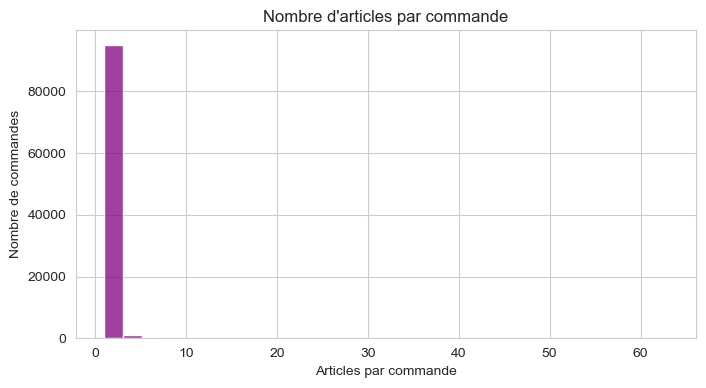

In [103]:
articles_per_order = data.groupby('order_id')['order_item_id'].count()
plt.figure(figsize=(8, 4))
sns.histplot(articles_per_order, bins=30, color='purple')
plt.title("Nombre d'articles par commande")
plt.xlabel("Articles par commande")
plt.ylabel("Nombre de commandes")
plt.show()

In [ ]:
from fonctions import plot_bar_count

colonnes = ['customer_state', 'seller_state', 'payment_type', 'nb_total_order', 'nb_total_item']

for col in colonnes:
    plot_bar_count(data_cust, col, top_n=10)

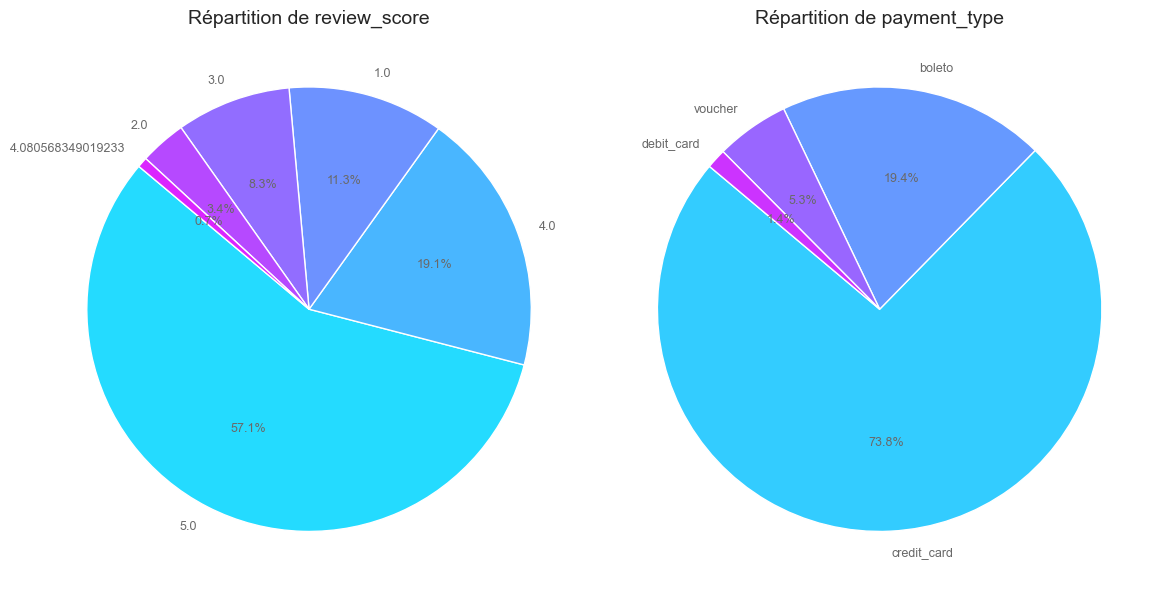

In [105]:
from fonctions import pie_plot

pie_plot(data, ['review_score', 'payment_type'])

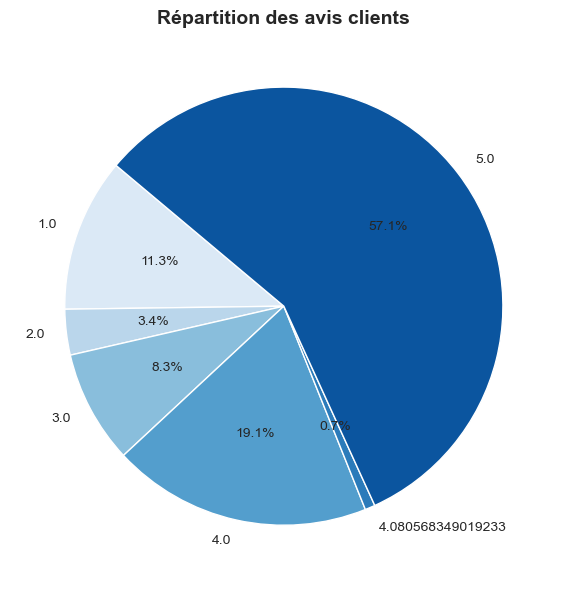

In [106]:
# Comptage des clients par review_score
review_counts = data['review_score'].value_counts().sort_index()

colors = sns.color_palette("Blues", n_colors=len(review_counts))

plt.figure(figsize=(6, 6))
plt.pie(
    review_counts,
    labels=review_counts.index.astype(str),
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor': 'white'}
)
plt.title("Répartition des avis clients", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

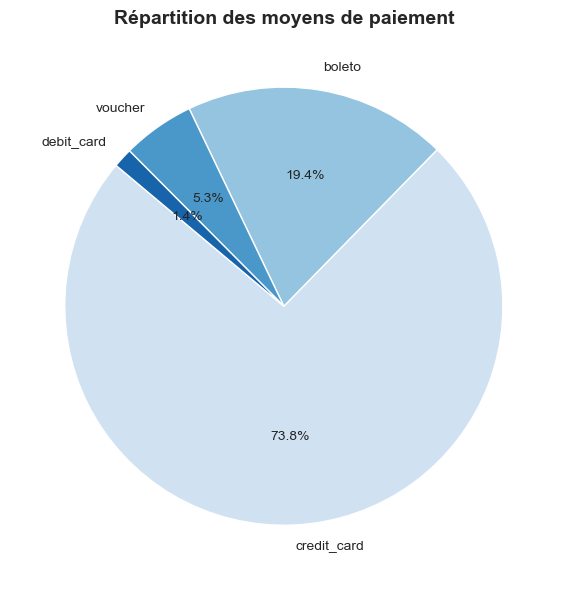

In [107]:
# Comptage des clients par payment_type
payment_counts = data['payment_type'].value_counts()

colors = sns.color_palette("Blues", n_colors=len(payment_counts))

plt.figure(figsize=(6, 6))
plt.pie(
    payment_counts,
    labels=payment_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor': 'white'}
)
plt.title("Répartition des moyens de paiement", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

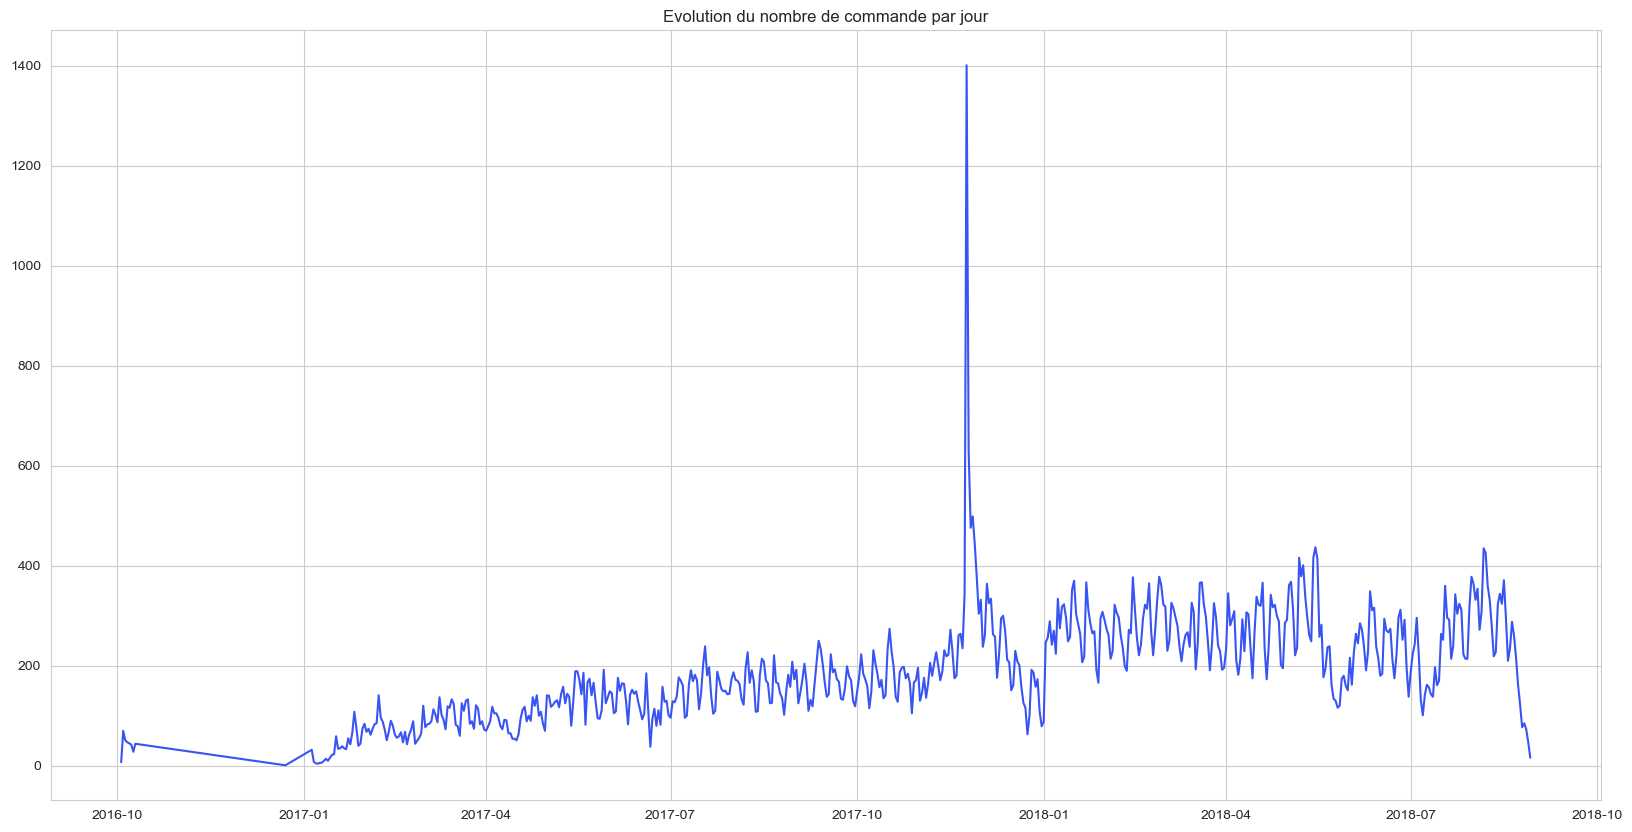

In [108]:
order_day = data.groupby(data['order_purchase_timestamp'].dt.date)\
    .agg({'order_id': 'count'})

plt.figure(figsize=(20, 10))
plt.plot(order_day)
plt.title('Evolution du nombre de commande par jour')
plt.show()

On constate que le nombre de commande semble plus important à partir de 2017. De plus, il y a un grand nombre de commande en fin d'année 2017 qui semble correspondre aux périodes de fêtes.

Nous pouvons, de la même façon, observer la répartition du nombre de commandes en fonction des mois.

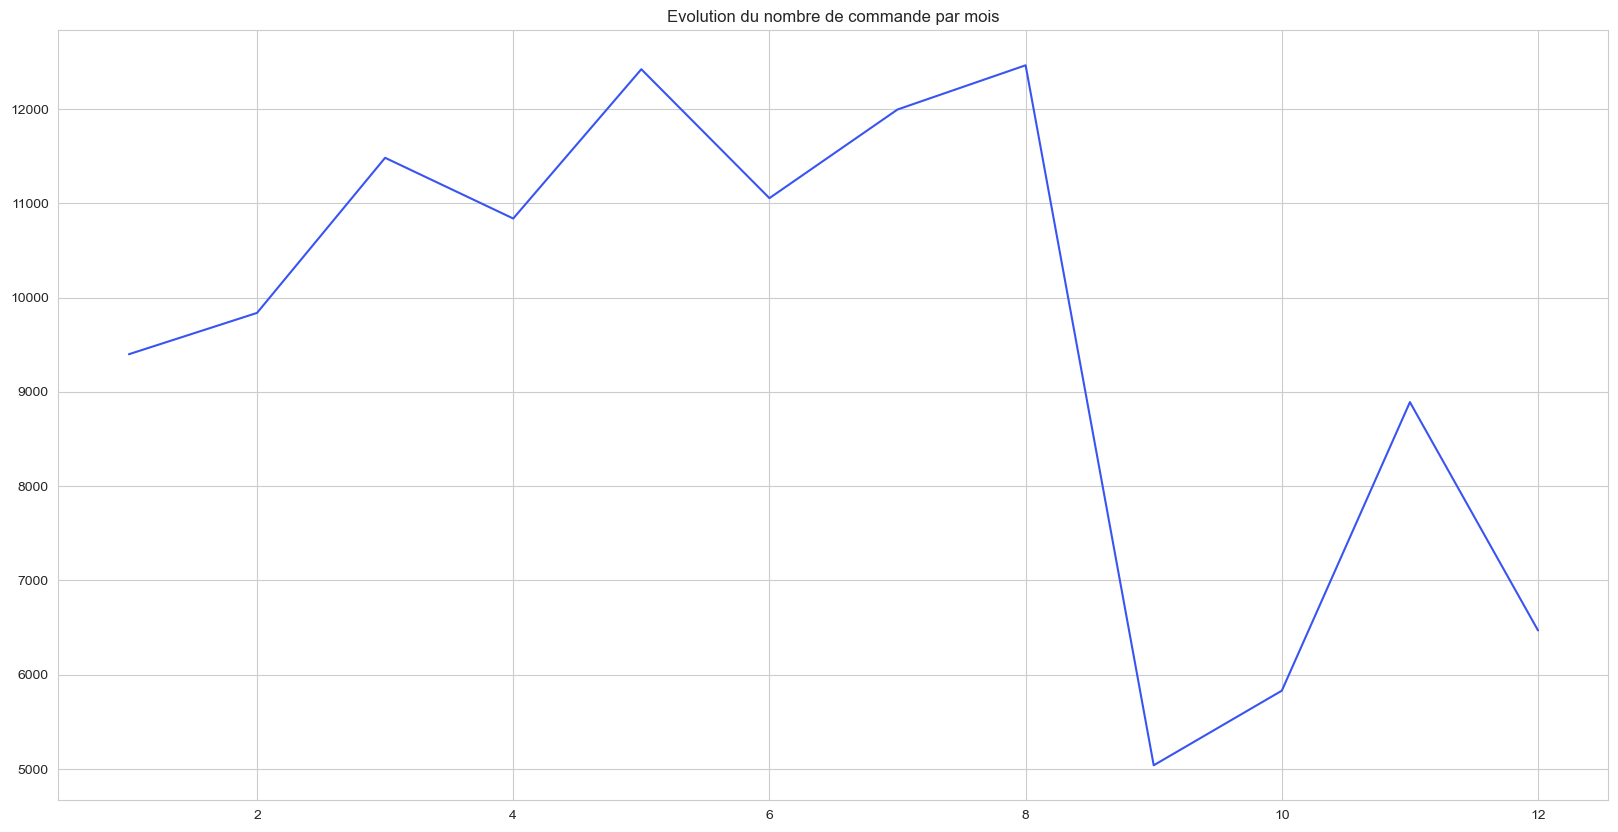

In [109]:
order_month = data.groupby(data['order_purchase_timestamp'].dt.month)\
    .agg({'order_id': 'count'})

plt.figure(figsize=(20, 10))
plt.plot(order_month)
plt.title('Evolution du nombre de commande par mois')
plt.show()

Ce graphique nous permet de constater que la plupart des commandes sont passées entre mars et aout. On observe également un pic en fin d'année avant la période des fêtes. En revanche, après l'été, vers la rentrée scolaire, peu de commandes sont passées.

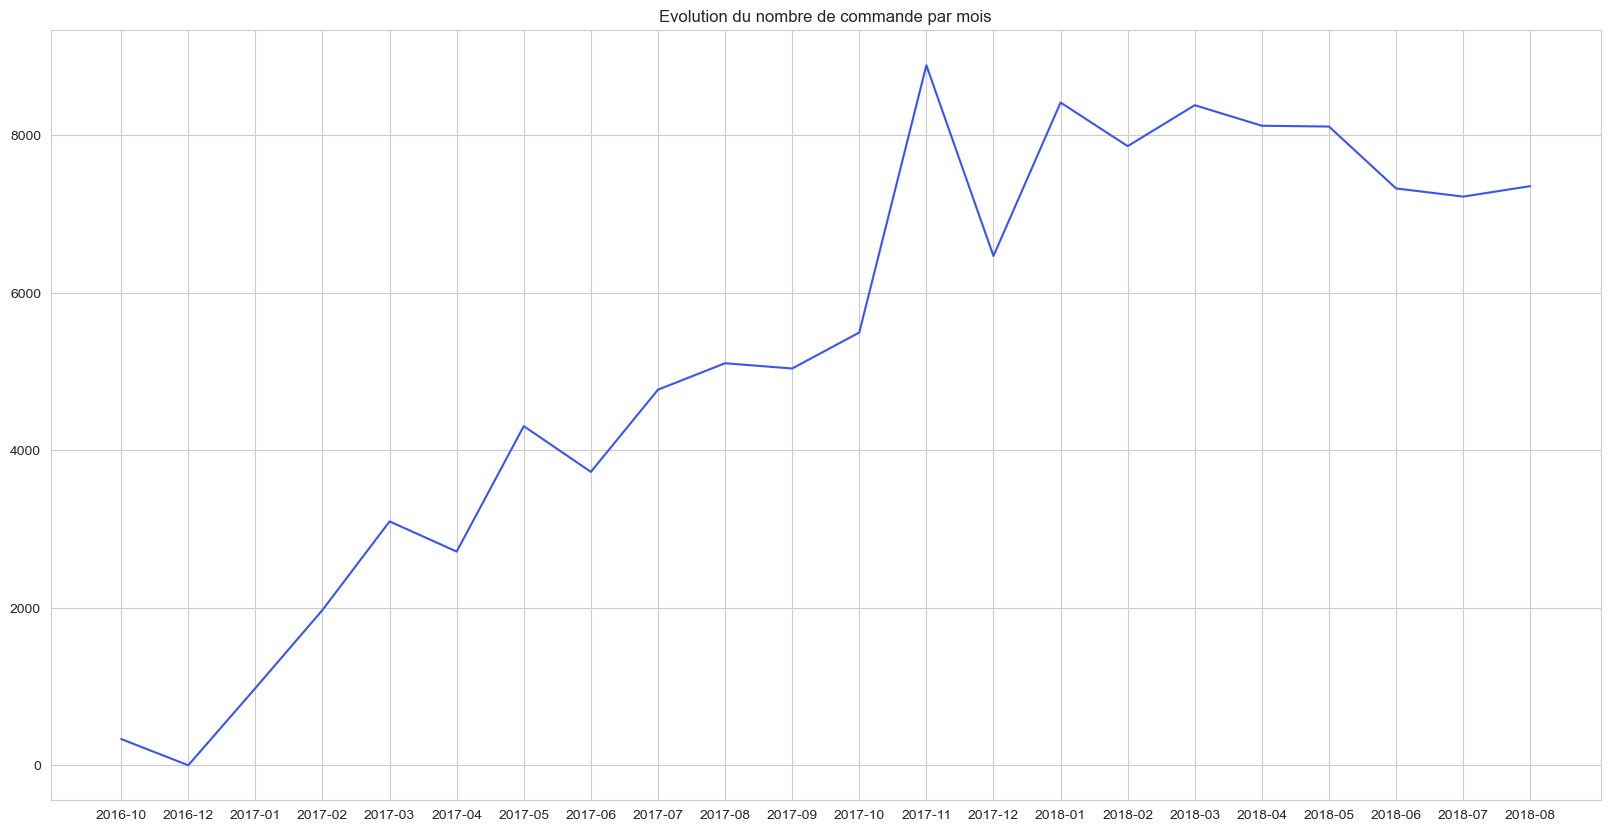

In [110]:
order_month = data.groupby(data['order_purchase_timestamp']
                           .dt.strftime('%Y-%m'))\
    .agg({'order_id': 'count'})

plt.figure(figsize=(20, 10))
plt.plot(order_month)
plt.title('Evolution du nombre de commande par mois')
plt.show()

On observe une tendance haussière au fur et à mesure des années. Un pic est atteint en fin d'année 2017, à la période des fêtes.

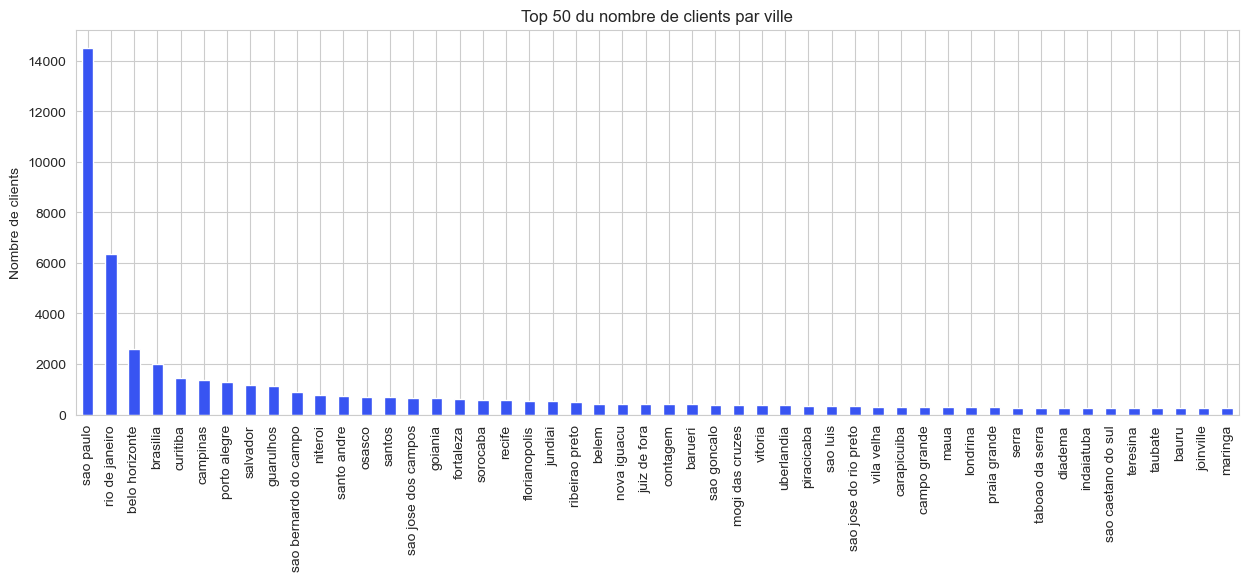

In [111]:
# Quelles villes habitent les clients ?
(
    data_cust['customer_city']
    .value_counts()
    .sort_values(ascending=False)
    .head(50)
    .plot(kind='bar', figsize=(15, 5))
)

plt.title('Top 50 du nombre de clients par ville')
plt.ylabel('Nombre de clients');

Les clients viennent de 4119 villes différentes, Sao Paulo étant la ville où vit la majorité des clients. Au total, le Brésil compte 5 570 communes.

Il y a plus de 96 000 clients. 16% d'entre eux vivent à São Paulo, qui est de loin la plus grande des 4 119 villes répertoriées. Il convient de garder ce déséquilibre à l'esprit lorsque l'on tire des conclusions.

In [112]:
# De quels Etats viennent-ils ?
data_cust['customer_state'].nunique()

27

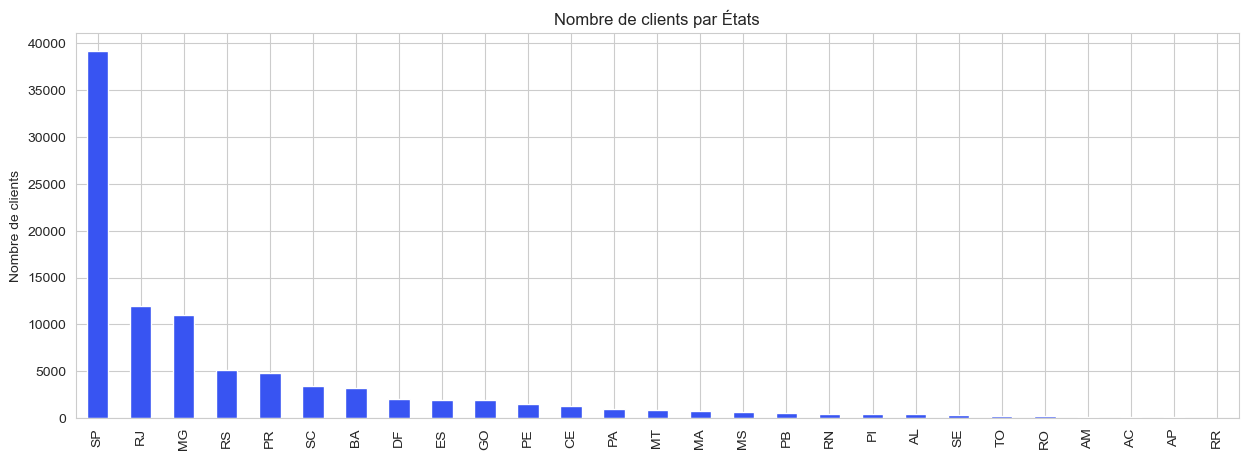

In [113]:
(
    data_cust['customer_state']
    .value_counts()
    .sort_values(ascending=False)
    .plot(kind='bar', figsize=(15, 5))
)

plt.title('Nombre de clients par États')
plt.ylabel('Nombre de clients');

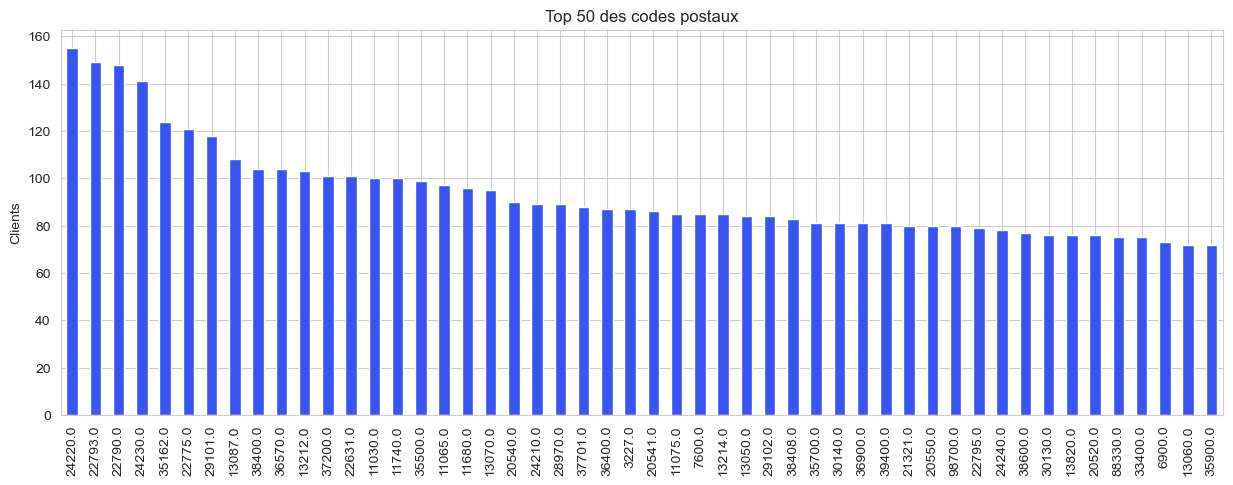

In [114]:
# Le top 50 des codes postaux des clients
(
    data['customer_zip_code_prefix']
    .value_counts()
    .sort_values(ascending=False)
    .head(50)
    .plot(kind='bar', figsize=(15, 5))
    )

plt.title('Top 50 des codes postaux')
plt.ylabel('Clients');

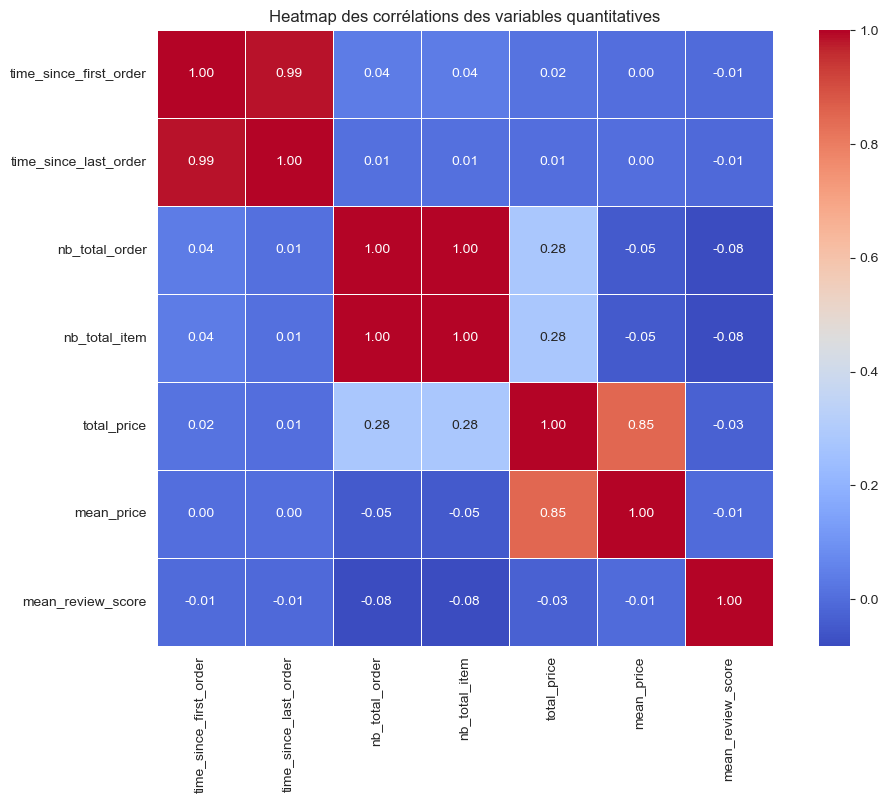

In [115]:
# Sélection des colonnes quantitatives dans data_cust
df_quanti = data_cust[col_quanti]

# Calcul de la matrice de corrélation
corr_matrix = df_quanti.corr()

# Affichage de la heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=0.5)
plt.title('Heatmap des corrélations des variables quantitatives')
plt.show()